In [1]:
import ROOT as rt
import array as arr
import math

from strangehelper import get_parabola, make_mixed_corrections

Welcome to JupyROOT 6.24/06


In [2]:
# epsilon used to avoid bin edge nightmares (if you pick a value that lies on bin edge, it defaults to right bin)
EPSILON = 0.00001

In [3]:
# side band subtraction method
USE_LSB = 0
USE_RSB = 0
USE_BOTH = 1 
assert sum([USE_LSB, USE_RSB, USE_BOTH]) == 1, "Only select 1 method for sideband subtraction please"

In [4]:
# UE line method
USE_AVG = 1
USE_ZYAM = 0
USE_NONEG = 0
assert sum([USE_AVG, USE_ZYAM, USE_NONEG]) == 1, "Only select 1 method for UE line please"

In [5]:
# DELTA_ETA_MAX = 0.6 - EPSILON
DELTA_ETA_MIN = -0.8
DELTA_ETA_MAX = 0.8 - EPSILON 

In [39]:
TRIG_PT_LOW = 4 
TRIG_PT_HIGH = 8 - EPSILON
ASSOC_PT_LOW = 2
ASSOC_PT_HIGH = 4 - EPSILON

In [40]:
LSB_MIN = 1.085
LSB_MAX = 1.10 - EPSILON
SIG_MIN = 1.104 
SIG_MAX = 1.129 - EPSILON
RSB_MIN = 1.13
RSB_MAX = 1.16 - EPSILON

In [41]:
c = rt.TCanvas("main_canvas", "Main Canvas", 55, 55, 800, 700)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: main_canvas


In [42]:
input_file_0_20 = rt.TFile("../online/closure/v0/AnalysisResults.root")
#input_file_0_20 = rt.TFile("../online/closure/v0/output/cent_0_20_larger_stat_more_dists.root")
input_list_0_20 = input_file_0_20.Get("h-lambda")

In [43]:
trig_dist_0_20 = input_list_0_20.FindObject("fTriggerDistEff_checkMC")
lambda_dist_0_20 = input_list_0_20.FindObject("fLambdaDist")
trig_dist_0_20_mc = input_list_0_20.FindObject("fTriggerDist_MC")
lambda_dist_0_20_mc = input_list_0_20.FindObject("fLambdaDist_MC")

In [44]:
h_h_0_20 = input_list_0_20.FindObject("fDphiHProton")
h_h_mixed_0_20 = input_list_0_20.FindObject("fDphiHProtonMixed")
h_h_0_20_mc = input_list_0_20.FindObject("fDphiHProton_MC")
h_h_mixed_0_20_mc = input_list_0_20.FindObject("fDphiHProtonMixed_MC")

In [45]:
h_lambda_0_20 = input_list_0_20.FindObject("fDphiHLambdaEff_MCKin_physicalPrimary")
h_lambda_mixed_0_20 = input_list_0_20.FindObject("fDphiHLambdaMixed_MCKin_physicalPrimary")
h_lambda_0_20_mc = input_list_0_20.FindObject("fDphiHLambda_MC_physicalPrimary")
h_lambda_mixed_0_20_mc = input_list_0_20.FindObject("fDphiHLambdaMixed_MC_physicalPrimary")

In [46]:
# Setting the trigger Pt (this is never changed again)
trig_dist_0_20.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_0_20.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_mixed_0_20.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_0_20.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_mixed_0_20.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
trig_dist_0_20_mc.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_0_20_mc.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_mixed_0_20_mc.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_0_20_mc.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_mixed_0_20_mc.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)

In [47]:
# Setting the associated Pt (this is never changed again)
lambda_dist_0_20.GetAxis(0).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_0_20.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_mixed_0_20.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_0_20.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_mixed_0_20.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
lambda_dist_0_20_mc.GetAxis(0).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_0_20_mc.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_mixed_0_20_mc.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_0_20_mc.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_mixed_0_20_mc.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)

In [48]:
trig_pt_dist_0_20 = trig_dist_0_20.Projection(0).Clone("trig_pt_dist_0_20")
trig_phi_dist_0_20 = trig_dist_0_20.Projection(1).Clone("trig_phi_dist_0_20")
trig_eta_dist_0_20 = trig_dist_0_20.Projection(2).Clone("trig_eta_dist_0_20")
trig_2d_dist_0_20 = trig_dist_0_20.Projection(0, 3).Clone("trig_2d_dist_0_20")

trig_pt_dist_0_20.SetTitle("Trigger #font[12]{p}_{T} Distribution (red: reconstruced, blue: MC truth)")
trig_pt_dist_0_20.Sumw2()
trig_pt_dist_0_20.SetLineColor(rt.kRed)

trig_phi_dist_0_20.SetTitle("Trigger #varphi Distribution (red: reconstructed, blue: MC truth")
trig_phi_dist_0_20.Sumw2()
trig_phi_dist_0_20.SetLineColor(rt.kRed)

trig_eta_dist_0_20.SetTitle("Trigger #eta Distribution (red: reconstructed, blue: MC truth")
trig_eta_dist_0_20.Sumw2()
trig_eta_dist_0_20.SetLineColor(rt.kRed)

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


In [49]:
trig_pt_dist_0_20_mc = trig_dist_0_20_mc.Projection(0).Clone("trig_pt_dist_0_20_mc")
trig_phi_dist_0_20_mc = trig_dist_0_20_mc.Projection(1).Clone("trig_phi_dist_0_20_mc")
trig_eta_dist_0_20_mc = trig_dist_0_20_mc.Projection(2).Clone("trig_eta_dist_0_20_mc")
trig_2d_dist_0_20_mc = trig_dist_0_20_mc.Projection(0, 3).Clone("trig_2d_dist_0_20_mc")

trig_pt_dist_0_20_mc.SetTitle("Trigger #font[12]{p}_{T} Distribution (red: reconstruced, blue: MC truth)")
trig_pt_dist_0_20_mc.Sumw2()
trig_pt_dist_0_20_mc.SetLineColor(rt.kBlue)

trig_phi_dist_0_20_mc.SetTitle("Trigger #varphi Distribution (red: reconstructed, blue: MC truth")
trig_phi_dist_0_20_mc.Sumw2()
trig_phi_dist_0_20_mc.SetLineColor(rt.kBlue)

trig_eta_dist_0_20_mc.SetTitle("Trigger #eta Distribution (red: reconstructed, blue: MC truth")
trig_eta_dist_0_20_mc.Sumw2()
trig_eta_dist_0_20_mc.SetLineColor(rt.kBlue)

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


In [50]:
num_trigs_0_20 = trig_2d_dist_0_20.Integral()
num_trigs_0_20_mc = trig_2d_dist_0_20_mc.Integral()

In [51]:
trig_pt_dist_0_20.Rebin(4)
trig_pt_dist_0_20_mc.Rebin(4)

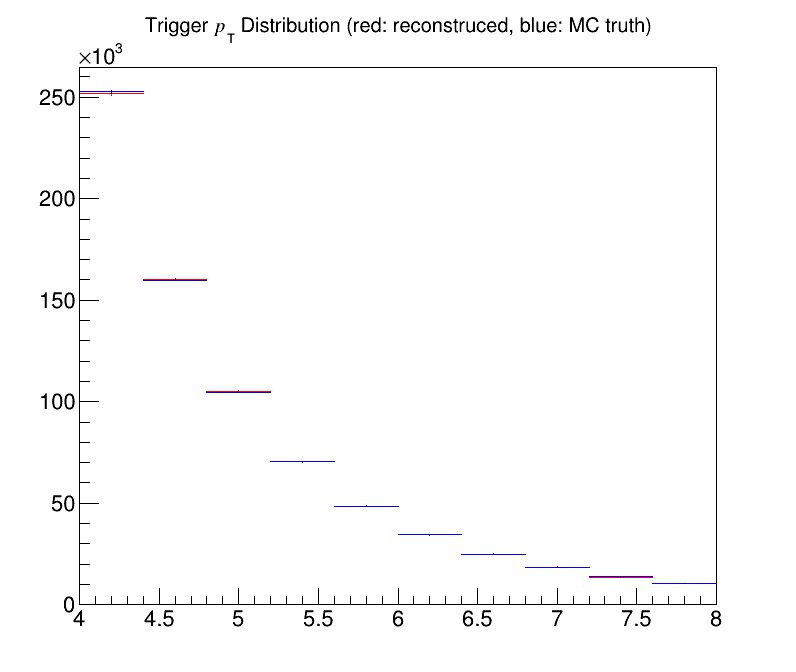

In [52]:
trig_pt_dist_0_20.Draw()
rt.gStyle.SetOptStat(0)
trig_pt_dist_0_20_mc.Draw("SAME")
c.Draw()


****************************************
Minimizer is Linear / Migrad
Chi2                      =      7.25308
NDf                       =            9
p0                        =      1.00017   +/-   0.00171704  


Info in <TCanvas::Print>: pdf file test.pdf has been created


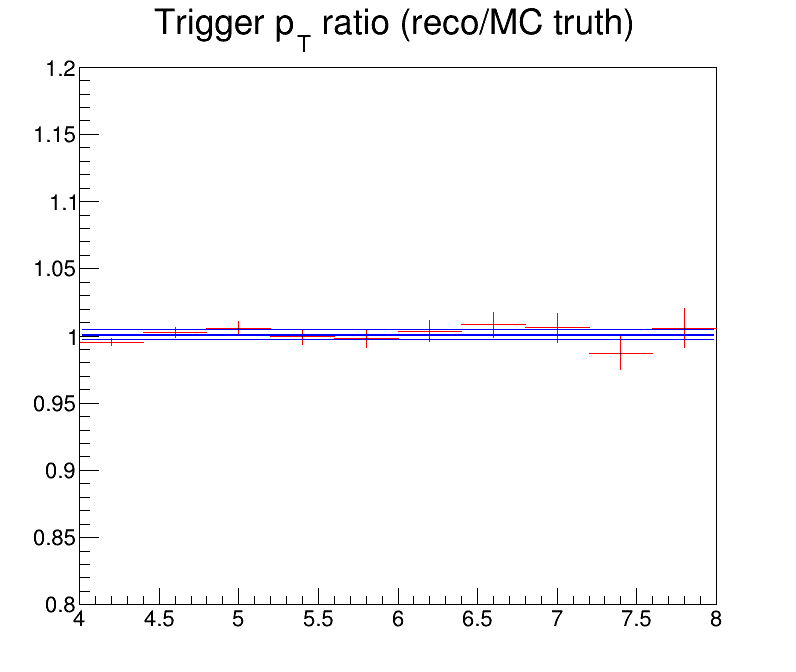

In [53]:
trig_pt_closure_ratio_0_20_fit = rt.TF1("trig_pt_closure_ratio_fit_0_20", "pol0", 4, 8)
trig_pt_closure_ratio_0_20_fit.SetLineColor(rt.kBlue)
trig_pt_closure_ratio_0_20_fit_plus = rt.TF1("trig_pt_closure_ratio_fit_0_20_plus", "pol0", 4, 8)
trig_pt_closure_ratio_0_20_fit_plus.SetLineColor(rt.kBlue)
trig_pt_closure_ratio_0_20_fit_minus = rt.TF1("trig_pt_closure_ratio_fit_0_20_minus", "pol0", 4, 8)
trig_pt_closure_ratio_0_20_fit_minus.SetLineColor(rt.kBlue)
trig_pt_closure_ratio_0_20_fit_minus.SetParameter(0, 1.00129 - 0.00355182)
trig_pt_closure_ratio_0_20_fit_plus.SetLineStyle(10)
trig_pt_closure_ratio_0_20_fit_plus.SetLineWidth(1)
trig_pt_closure_ratio_0_20_fit_minus.SetLineStyle(10)
trig_pt_closure_ratio_0_20_fit_minus.SetLineWidth(1)
trig_pt_closure_ratio_0_20_fit_plus.SetParameter(0, 1.00129 + 0.00355182)
trig_pt_closure_ratio_0_20_fit.SetLineStyle(10)
trig_pt_closure_ratio_0_20_fit.SetLineWidth(2)
trig_pt_dist_0_20_ratio = trig_pt_dist_0_20.Clone("trig_pt_dist_0_20_ratio")
trig_pt_dist_0_20_ratio.Divide(trig_pt_dist_0_20_ratio, trig_pt_dist_0_20_mc, 1, 1)
trig_pt_dist_0_20_ratio.GetYaxis().SetRangeUser(0.8, 1.2)
trig_pt_dist_0_20_ratio.SetTitle("Trigger p_{T} ratio (reco/MC truth)")
res = trig_pt_dist_0_20_ratio.Fit(trig_pt_closure_ratio_0_20_fit)
trig_pt_dist_0_20_ratio.Draw()
trig_pt_closure_ratio_0_20_fit_minus.Draw("SAME")
trig_pt_closure_ratio_0_20_fit_plus.Draw("SAME")
c.Draw()
c.SaveAs("test.pdf")

In [54]:
trig_pt_dist_0_20.Scale(1/num_trigs_0_20)
trig_pt_dist_0_20_mc.Scale(1/num_trigs_0_20_mc)

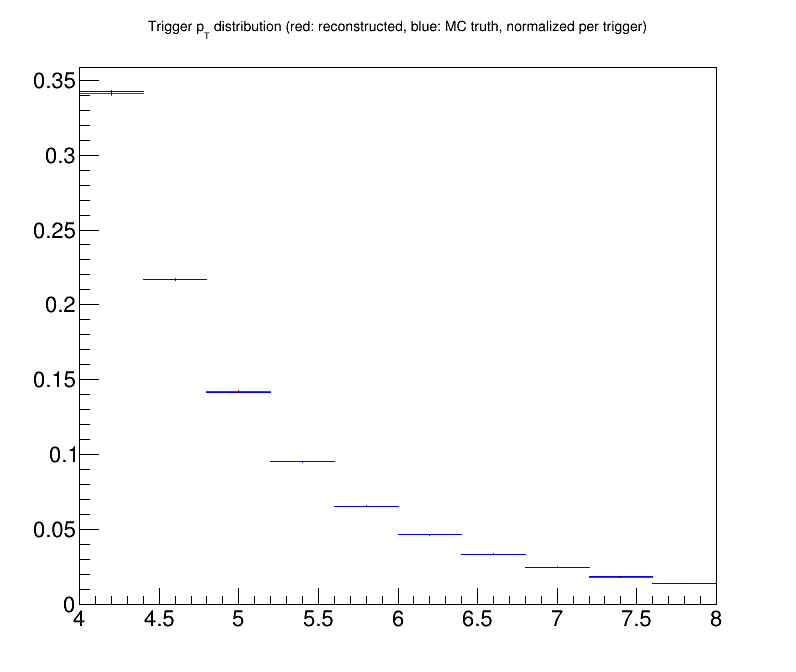

In [55]:
trig_pt_dist_0_20.SetTitle("Trigger p_{T} distribution (red: reconstructed, blue: MC truth, normalized per trigger)")
trig_pt_dist_0_20.Draw()
trig_pt_dist_0_20_mc.Draw("SAME")
c.Draw()

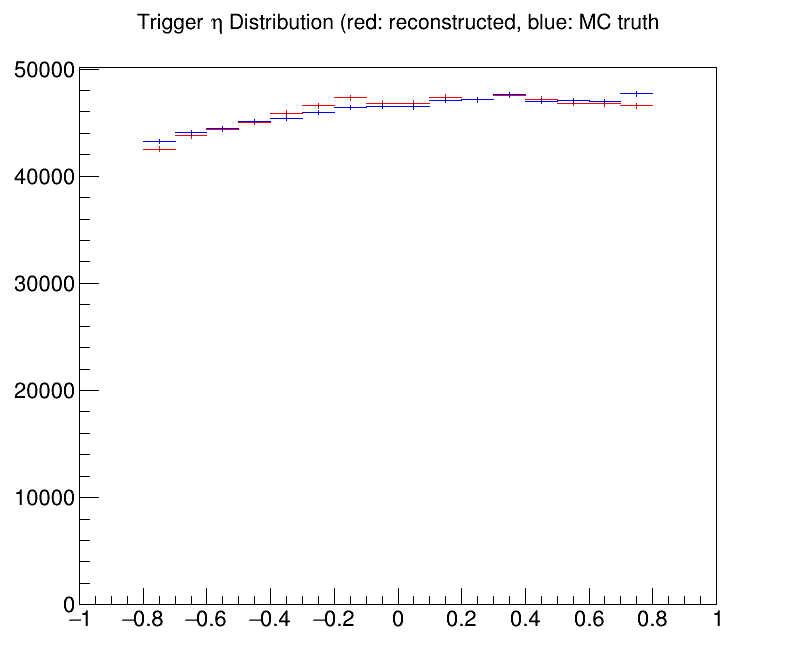

In [56]:
trig_eta_dist_0_20.Draw()
trig_eta_dist_0_20_mc.Draw("SAME")
c.Draw()

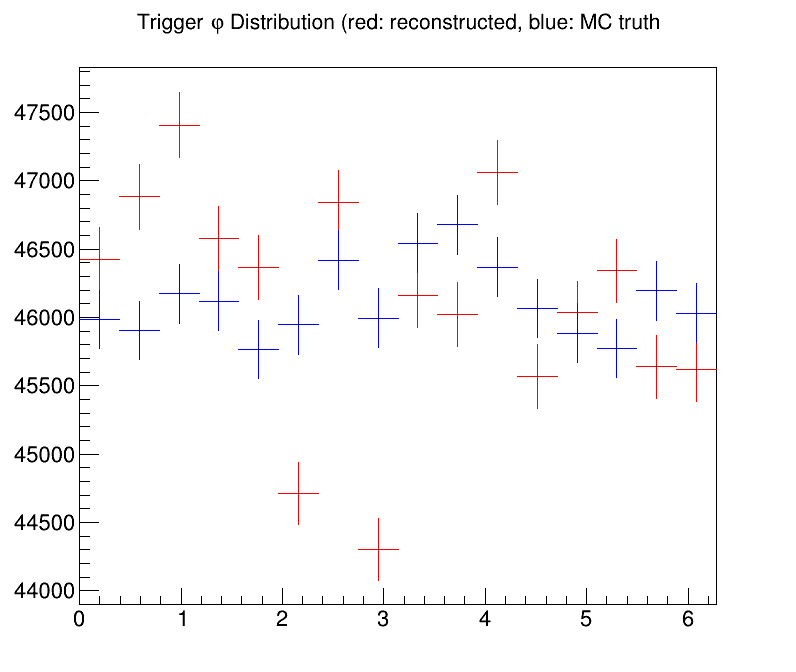

In [57]:
trig_phi_dist_0_20.Draw()
trig_phi_dist_0_20_mc.Draw("SAME")
c.Draw()

### Signal analysis section

In [58]:
# eta cuts first
lambda_dist_0_20.GetAxis(2).SetRangeUser(-0.8, 0.8)
lambda_dist_0_20_mc.GetAxis(2).SetRangeUser(-0.8, 0.8)
lambda_mass_dist_0_20 = lambda_dist_0_20.Projection(3).Clone("lambda_mass_dist_0_20")
lambda_mass_dist_0_20_mc = lambda_dist_0_20_mc.Projection(3).Clone("lambda_mass_dist_0_20_mc")

In [59]:
lambda_mass_dist_0_20.SetTitle("#Lambda^{0} invariant mass distribution (p-#pi)")
lambda_mass_dist_0_20.Sumw2()
lambda_mass_dist_0_20.SetLineWidth(2)
lambda_mass_dist_0_20.GetXaxis().SetTitle("Mass (GeV/c^{2})")
lambda_mass_dist_0_20.GetYaxis().SetTitle("#frac{dN_{p-#pi}}{dM}")

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


506434.35133731365


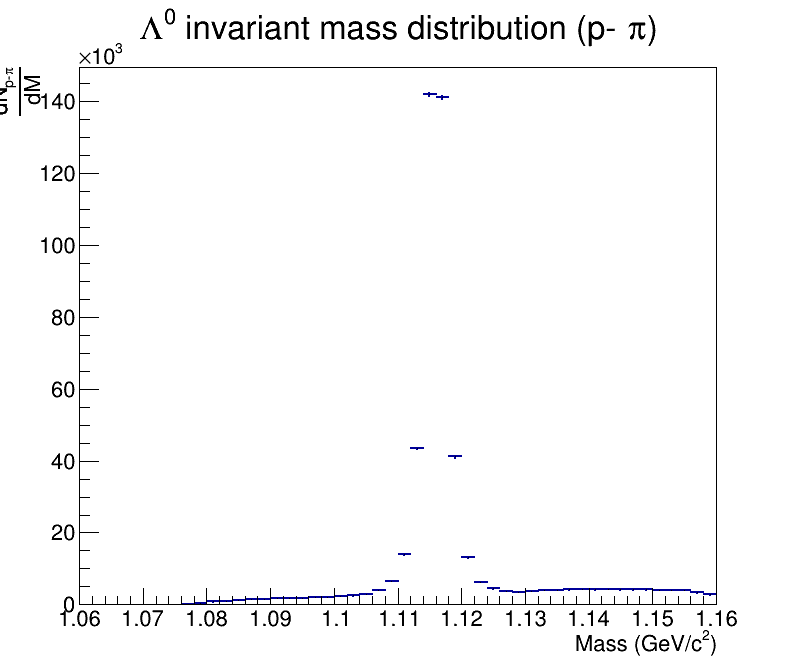

In [60]:
lambda_mass_dist_0_20.Rebin(2)
lambda_mass_dist_0_20.Draw()
print(lambda_mass_dist_0_20.Integral())
c.Draw()

In [61]:
bin_1 = lambda_mass_dist_0_20.FindBin(1.09)
bin_2 = lambda_mass_dist_0_20.FindBin(1.15)
bin_3 = lambda_mass_dist_0_20.FindBin(1.16 - EPSILON)
point_one = [1.09, lambda_mass_dist_0_20.GetBinContent(bin_1)]
point_two = [1.15, lambda_mass_dist_0_20.GetBinContent(bin_2)]
point_three = [1.16, lambda_mass_dist_0_20.GetBinContent(bin_3)]
bg_starting_params_0_20 = get_parabola(point_one, point_two, point_three)

In [62]:
lambda_mass_fit_0_20 = rt.TF1("lambda_mass_fit_0_20", "[0]*TMath::Voigt(x - [1], [2], [3], 4) + pol2(4)", 1.09, 1.155)
lambda_mass_fit_0_20.SetNpx(1000)
lambda_mass_fit_0_20.SetParameter(0, 1.36753e00)
lambda_mass_fit_0_20.SetParameter(1, 1.116)
lambda_mass_fit_0_20.SetParameter(2, 1.00576e-03)
lambda_mass_fit_0_20.SetParameter(3, 6.04166e-03)
lambda_mass_fit_0_20.SetParameter(4, bg_starting_params_0_20[0])
lambda_mass_fit_0_20.SetParameter(5, bg_starting_params_0_20[1])
lambda_mass_fit_0_20.SetParameter(6, bg_starting_params_0_20[2])

 FCN=101205 FROM MIGRAD    STATUS=FAILED       1828 CALLS        1829 TOTAL
                     EDM=177.895    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           4.07551e+00   1.25750e-01  -0.00000e+00  -9.09097e-01
   2  p1           1.11500e+00   7.27969e-06  -0.00000e+00   3.58262e+06
   3  p2           6.08452e-09   8.73431e-12   0.00000e+00   0.00000e+00
   4  p3           1.88640e-05   5.31005e-07   0.00000e+00  -4.99484e+05
   5  p4          -3.19209e+06   2.34975e+01  -0.00000e+00   4.93959e-03
   6  p5           5.66687e+06   2.10168e+01  -0.00000e+00   5.13235e-03
   7  p6          -2.51100e+06   1.87556e+01  -0.00000e+00   6.19497e-03


Warning in <Fit>: Abnormal termination of minimization.


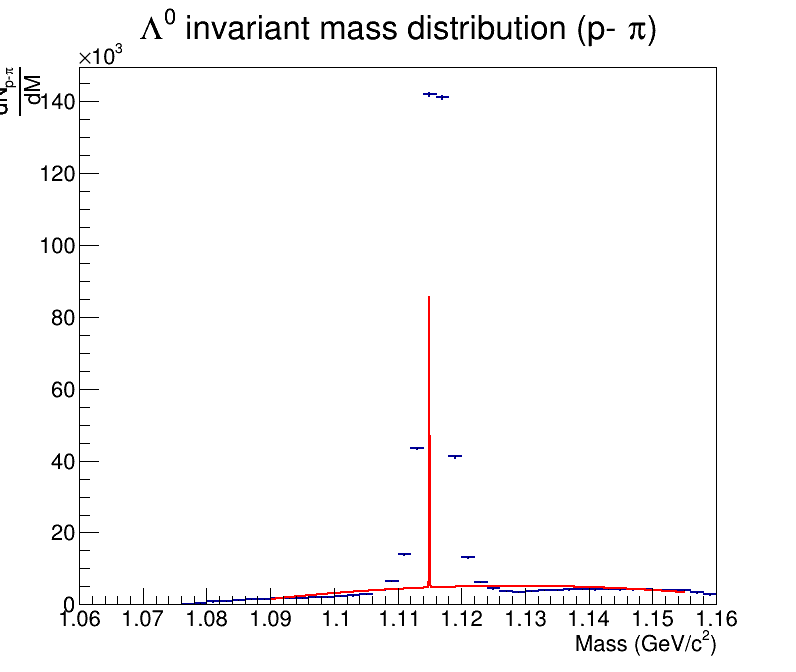

In [63]:
lambda_mass_dist_fit_0_20 = lambda_mass_dist_0_20.Clone("lambda_mass_dist_fit_0_20")
lambda_mass_dist_fit_0_20.Fit(lambda_mass_fit_0_20, "RS")
lambda_mass_dist_fit_0_20.Draw()
c.Draw()

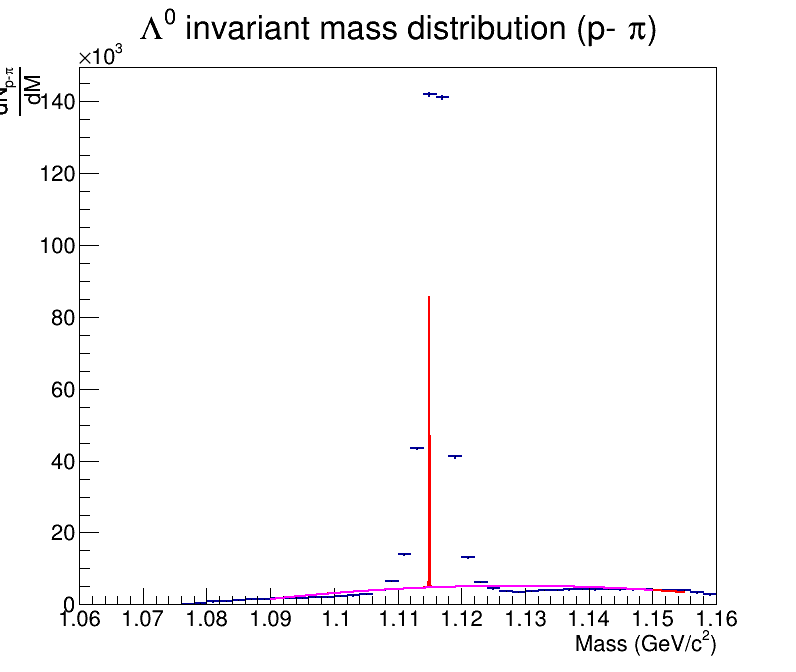

In [64]:
bg_fit_0_20 = rt.TF1("bg_fit_0_20", "pol2", 1.09, 1.15)
bg_fit_0_20.SetParameter(0, lambda_mass_fit_0_20.GetParameter(4))
bg_fit_0_20.SetParameter(1, lambda_mass_fit_0_20.GetParameter(5))
bg_fit_0_20.SetParameter(2, lambda_mass_fit_0_20.GetParameter(6))
bg_fit_0_20.SetNpx(1000)
bg_fit_0_20.SetLineColor(rt.kMagenta)
bg_fit_0_20.Draw("SAME")
c.Draw()

In [65]:
left_signal_bin_0_20 = lambda_mass_dist_fit_0_20.FindBin(SIG_MIN)
right_signal_bin_0_20 = lambda_mass_dist_fit_0_20.FindBin(SIG_MAX)

lambda_bg_0_20 = 0
lambda_total_0_20 = 0
for bin_num in range(left_signal_bin_0_20, right_signal_bin_0_20 + 1):
    bin_center = lambda_mass_dist_fit_0_20.GetBinCenter(bin_num)
    lambda_bg_0_20 += bg_fit_0_20.Eval(bin_center)
    lambda_total_0_20 += lambda_mass_dist_fit_0_20.GetBinContent(bin_num)

lambda_signal_0_20 = lambda_total_0_20 - lambda_bg_0_20
lambda_signal_total_ratio_0_20 = lambda_signal_0_20/lambda_total_0_20
lambda_signal_bg_ratio_0_20 = lambda_signal_0_20/lambda_bg_0_20
print(f"The 0-20 lambda signal is: {lambda_signal_0_20}")
print(f"The 0-20 lambda background is: {lambda_bg_0_20}")
print(f"The 0-20 lambda S/B is: {lambda_signal_bg_ratio_0_20}")
print(f"The 0-20 lambda S/T is: {lambda_signal_total_ratio_0_20}")
print(f"The 0-20 lambda significance is: {lambda_signal_0_20/math.sqrt(lambda_signal_0_20 + lambda_bg_0_20)}")

The 0-20 lambda signal is: 365194.26874143817
The 0-20 lambda background is: 61176.715959122404
The 0-20 lambda S/B is: 5.969497757700117
The 0-20 lambda S/T is: 0.8565176380327881
The 0-20 lambda significance is: 559.2810853993972


397231.0
397231.0


Warning in <TFile::Append>: Replacing existing TH1: fLambdaDist_MC_proj_3 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: fLambdaDist_MC_proj_3 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: fLambdaDist_MC_proj_3 (Potential memory leak).


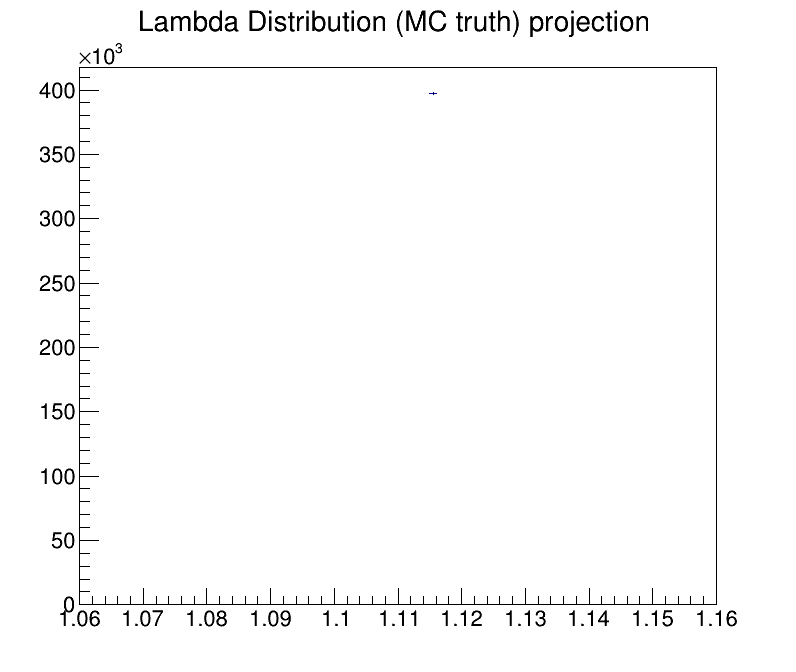

In [66]:
print(lambda_dist_0_20_mc.Projection(3).Integral())
print(lambda_dist_0_20_mc.Projection(3).Integral())
lambda_dist_0_20_mc.Projection(3).Draw()
c.Draw()

### Mixed event correction section

In [67]:
axes = arr.array('i', [2, 3, 4, 5])
h_lambda_0_20 = h_lambda_0_20.Projection(4, axes)
h_lambda_0_20_mc = h_lambda_0_20_mc.Projection(4, axes)
h_lambda_mixed_0_20 = h_lambda_mixed_0_20.Projection(4, axes)
h_lambda_mixed_0_20_mc = h_lambda_mixed_0_20_mc.Projection(4, axes)

In [68]:
h_h_0_20 = h_h_0_20.Projection(2, 3, 4)
h_h_0_20_mc = h_h_0_20_mc.Projection(2, 3, 4)
h_h_mixed_0_20 = h_h_mixed_0_20.Projection(2, 3, 4)
h_h_mixed_0_20_mc = h_h_mixed_0_20_mc.Projection(2, 3, 4)

In [69]:
# Setting up 2-d correlation plots before the mixed event correction
h_lambda_2d_nomixcor_0_20 = h_lambda_0_20.Projection(0, 1).Clone("h_lambda_2d_nomixcor_0_20")
h_lambda_2d_nomixcor_0_20_mc = h_lambda_0_20_mc.Projection(0, 1).Clone("h_lambda_2d_nomixcor_0_20_mc")
h_lambda_mixed_2d_0_20 = h_lambda_mixed_0_20.Projection(0, 1).Clone("h_lambda_mixed_2d_0_20")
h_lambda_mixed_2d_0_20_mc = h_lambda_mixed_0_20_mc.Projection(0, 1).Clone("h_lambda_mixed_2d_0_20_mc")

In [70]:
h_h_2d_nomixcor_0_20 = h_h_0_20_mc.Project3D("xye").Clone("h_h_2d_nomixcor_0_20")
h_h_2d_nomixcor_0_20_mc = h_h_0_20_mc.Project3D("xye").Clone("h_h_2d_nomixcor_0_20_mc")
h_h_mixed_2d_0_20 = h_h_mixed_0_20.Project3D("xye").Clone("h_h_mixed_2d_0_20")
h_h_mixed_2d_0_20_mc = h_h_mixed_0_20_mc.Project3D("xye").Clone("h_h_mixed_2d_0_20_mc")

In [71]:
h_lambda_2d_nomixcor_0_20.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta (no acceptance correction)")
h_lambda_2d_nomixcor_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_0_20.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_0_20.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_nomixcor_0_20.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_0_20.GetYaxis().SetTitleOffset(1.3)

h_lambda_mixed_2d_0_20.SetTitle("Mixed-event h-#Lambda^{0} #Delta#varphi#Delta#eta")
h_lambda_mixed_2d_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_mixed_2d_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_mixed_2d_0_20.GetXaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_0_20.GetXaxis().SetTitleOffset(1.3)
h_lambda_mixed_2d_0_20.GetYaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_0_20.GetYaxis().SetTitleOffset(1.3)

h_lambda_2d_nomixcor_0_20_mc.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta (no acceptance correction, MC truth)")
h_lambda_2d_nomixcor_0_20_mc.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_0_20_mc.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_0_20_mc.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_0_20_mc.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_nomixcor_0_20_mc.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_0_20_mc.GetYaxis().SetTitleOffset(1.3)

h_lambda_mixed_2d_0_20_mc.SetTitle("Mixed-event h-#Lambda^{0} #Delta#varphi#Delta#eta (MC truth)")
h_lambda_mixed_2d_0_20_mc.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_mixed_2d_0_20_mc.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_mixed_2d_0_20_mc.GetXaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_0_20_mc.GetXaxis().SetTitleOffset(1.3)
h_lambda_mixed_2d_0_20_mc.GetYaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_0_20_mc.GetYaxis().SetTitleOffset(1.3)

In [72]:
h_h_2d_nomixcor_0_20.SetTitle("h-h #Delta#varphi#Delta#eta (no acceptance correction)")
h_h_2d_nomixcor_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_2d_nomixcor_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_2d_nomixcor_0_20.GetXaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_0_20.GetXaxis().SetTitleOffset(1.3)
h_h_2d_nomixcor_0_20.GetYaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_0_20.GetYaxis().SetTitleOffset(1.3)

h_h_mixed_2d_0_20.SetTitle("Mixed-event h-h #Delta#varphi#Delta#eta")
h_h_mixed_2d_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_mixed_2d_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_mixed_2d_0_20.GetXaxis().SetTitleSize(0.05)
h_h_mixed_2d_0_20.GetXaxis().SetTitleOffset(1.3)
h_h_mixed_2d_0_20.GetYaxis().SetTitleSize(0.05)
h_h_mixed_2d_0_20.GetYaxis().SetTitleOffset(1.3)

h_h_2d_nomixcor_0_20_mc.SetTitle("h-h #Delta#varphi#Delta#eta (no acceptance correction, MC truth)")
h_h_2d_nomixcor_0_20_mc.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_2d_nomixcor_0_20_mc.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_2d_nomixcor_0_20_mc.GetXaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_0_20_mc.GetXaxis().SetTitleOffset(1.3)
h_h_2d_nomixcor_0_20_mc.GetYaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_0_20_mc.GetYaxis().SetTitleOffset(1.3)

h_h_mixed_2d_0_20_mc.SetTitle("Mixed-event h-h #Delta#varphi#Delta#eta (MC truth)")
h_h_mixed_2d_0_20_mc.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_mixed_2d_0_20_mc.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_mixed_2d_0_20_mc.GetXaxis().SetTitleSize(0.05)
h_h_mixed_2d_0_20_mc.GetXaxis().SetTitleOffset(1.3)
h_h_mixed_2d_0_20_mc.GetYaxis().SetTitleSize(0.05)
h_h_mixed_2d_0_20_mc.GetYaxis().SetTitleOffset(1.3)

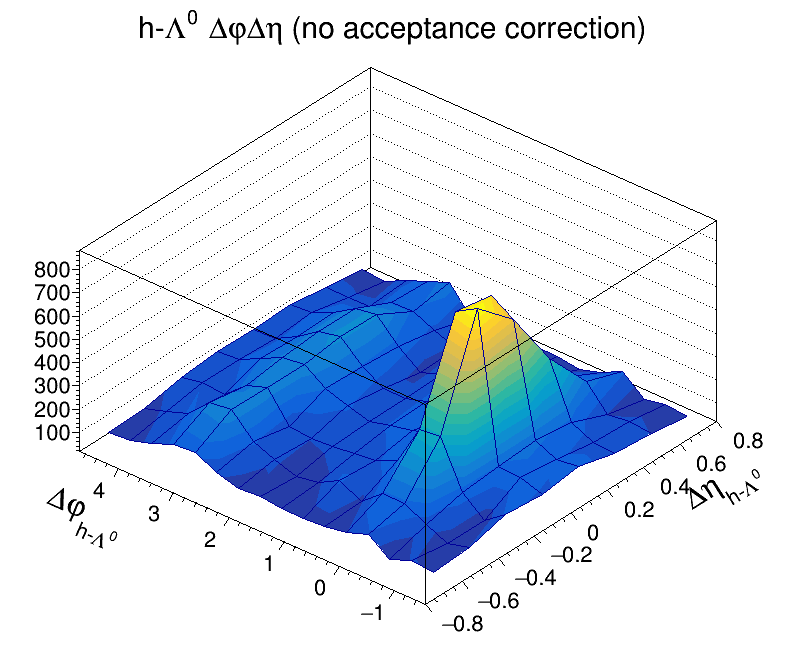

In [73]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_nomixcor_0_20.GetXaxis().SetRangeUser(DELTA_ETA_MIN, DELTA_ETA_MAX)
h_lambda_2d_nomixcor_0_20.Draw("SURF1")
c.Draw()

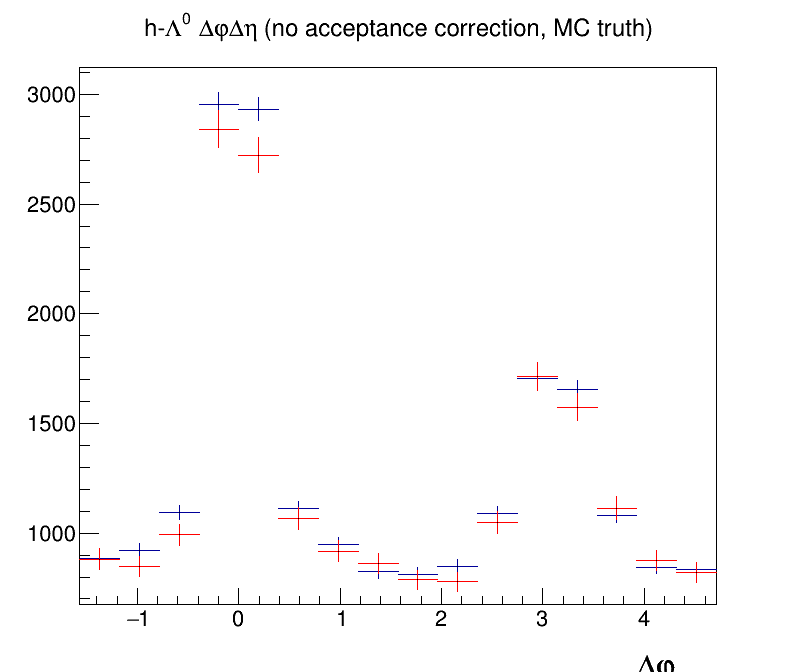

In [74]:
h_lambda_2d_nomixcor_0_20.GetXaxis().SetRangeUser(DELTA_ETA_MIN, DELTA_ETA_MAX)
h_lambda_2d_nomixcor_0_20_mc.GetXaxis().SetRangeUser(DELTA_ETA_MIN, DELTA_ETA_MAX)
h_lambda_2d_nomixcor_0_20.SetLineColor(rt.kRed)
test1 = h_lambda_2d_nomixcor_0_20.ProjectionY().Clone("test1")
test2 = h_lambda_2d_nomixcor_0_20_mc.ProjectionY().Clone("test2")
test2.Draw()
test1.Draw("SAME")
c.Draw()

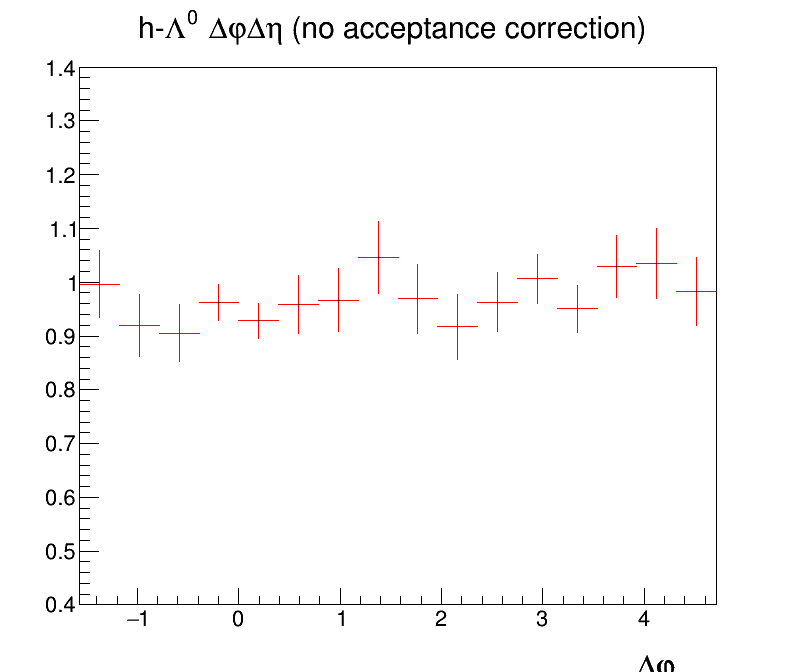

In [75]:
test1.Divide(test2)
test1.GetYaxis().SetRangeUser(0.4, 1.4)
test1.Draw()
c.Draw()

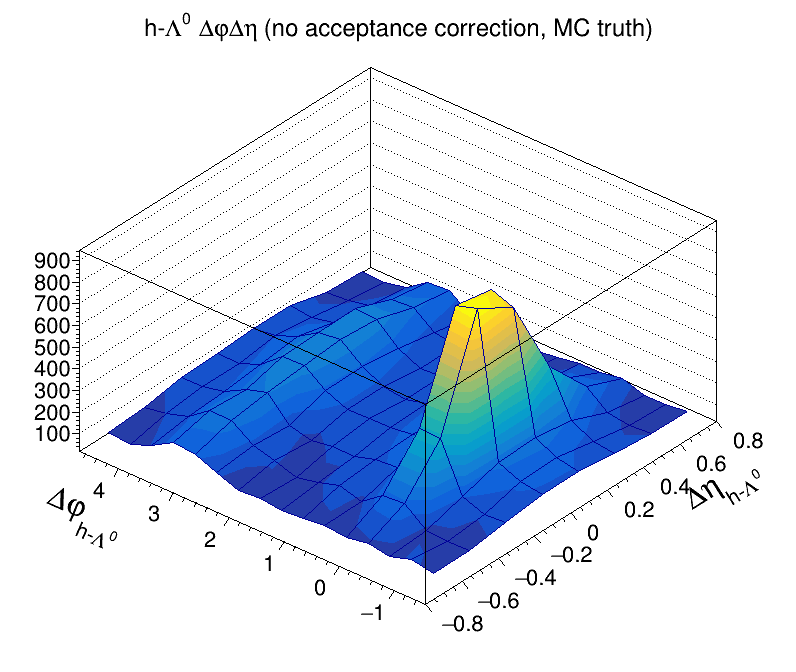

In [76]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_nomixcor_0_20_mc.GetXaxis().SetRangeUser(DELTA_ETA_MIN, DELTA_ETA_MAX)
h_lambda_2d_nomixcor_0_20_mc.Draw("SURF1")
c.Draw()

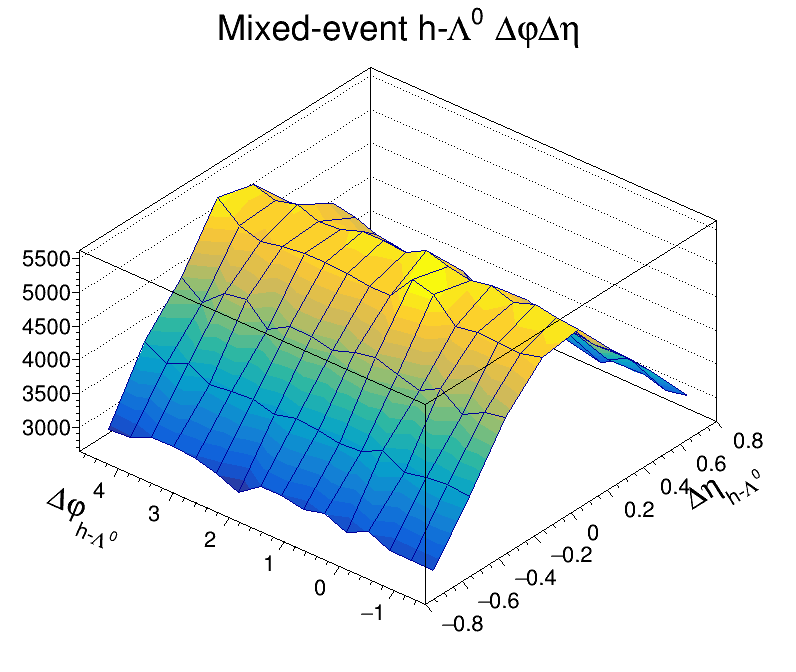

In [77]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_mixed_2d_0_20.GetXaxis().SetRangeUser(DELTA_ETA_MIN, DELTA_ETA_MAX)
h_lambda_mixed_2d_0_20.Draw("SURF1")
c.Draw()

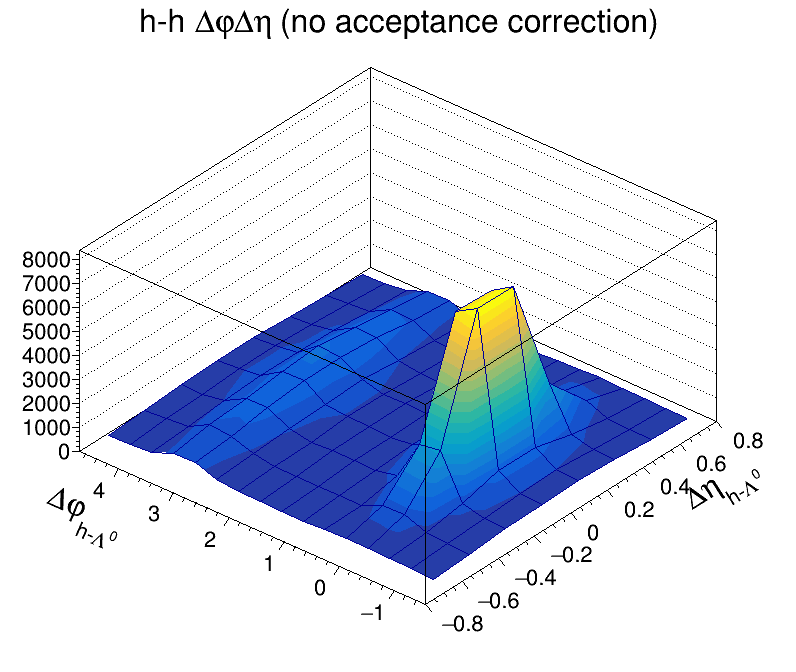

In [78]:
c.SetTheta(50)
c.SetPhi(50)
h_h_2d_nomixcor_0_20.GetXaxis().SetRangeUser(DELTA_ETA_MIN, DELTA_ETA_MAX)
h_h_2d_nomixcor_0_20.Draw("SURF1")
c.Draw()

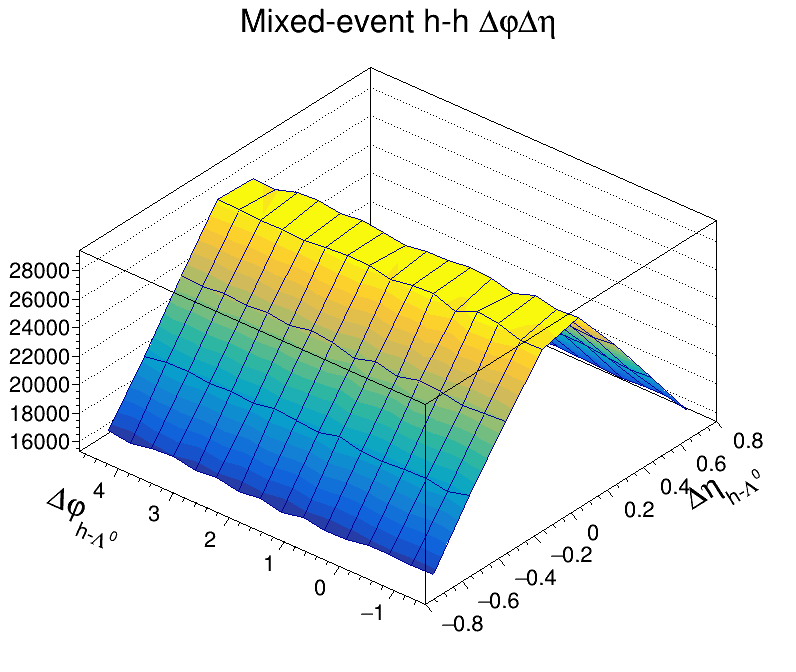

In [79]:
c.SetTheta(50)
c.SetPhi(50)
h_h_mixed_2d_0_20.GetXaxis().SetRangeUser(DELTA_ETA_MIN, DELTA_ETA_MAX)
h_h_mixed_2d_0_20.Draw("SURF1")
c.Draw()

In [80]:
h_lambda_2d_mixcor_lsb_0_20 = make_mixed_corrections(h_lambda_0_20, h_lambda_mixed_0_20, LSB_MIN, LSB_MAX)
h_lambda_2d_mixcor_sig_0_20 = make_mixed_corrections(h_lambda_0_20, h_lambda_mixed_0_20, SIG_MIN, SIG_MAX)
h_lambda_2d_mixcor_rsb_0_20 = make_mixed_corrections(h_lambda_0_20, h_lambda_mixed_0_20, RSB_MIN, RSB_MAX)

Warning in <TFile::Append>: Replacing existing TH1: fDphiHLambdaEff_MCKin_physicalPrimary_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TFile::Append>: Replacing existing TH1: fDphiHLambdaMixed_MCKin_physicalPrimary_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TFile::Append>: Replacing existing TH1: fDphiHLambdaEff_MCKin_physicalPrimary_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: fDphiHLambdaMixed_MCKin_physicalPrimary_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).


In [81]:
h_lambda_2d_mixcor_sig_0_20_mc = make_mixed_corrections(h_lambda_0_20_mc, h_lambda_mixed_0_20_mc, SIG_MIN, SIG_MAX)

Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created


In [82]:
h_h_2d_mixcor_0_20 = make_mixed_corrections(h_h_0_20, h_h_mixed_0_20, SIG_MIN, SIG_MAX, is_hh=True)
h_h_2d_mixcor_0_20_mc = make_mixed_corrections(h_h_0_20_mc, h_h_mixed_0_20_mc, SIG_MIN, SIG_MAX, is_hh=True)

Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created


In [83]:
h_lambda_2d_mixcor_lsb_0_20.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (LSB, acceptance corrected)")
h_lambda_2d_mixcor_lsb_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_lsb_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_lsb_0_20.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_lsb_0_20.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_mixcor_lsb_0_20.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_lsb_0_20.GetYaxis().SetTitleOffset(1.3)

h_lambda_2d_mixcor_sig_0_20.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (SIG, acceptance corrected)")
h_lambda_2d_mixcor_sig_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_sig_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_sig_0_20.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_sig_0_20.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_mixcor_sig_0_20.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_sig_0_20.GetYaxis().SetTitleOffset(1.3)

h_lambda_2d_mixcor_rsb_0_20.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (RSB, acceptance corrected)")
h_lambda_2d_mixcor_rsb_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_rsb_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_rsb_0_20.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_rsb_0_20.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_mixcor_rsb_0_20.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_rsb_0_20.GetYaxis().SetTitleOffset(1.3)

In [84]:
h_h_2d_mixcor_0_20.SetTitle("h-h #Delta#varphi#Delta#eta correlation (acceptance corrected)")
h_h_2d_mixcor_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-h}")
h_h_2d_mixcor_0_20.GetXaxis().SetTitle("#Delta#eta_{h-h}")
h_h_2d_mixcor_0_20.GetXaxis().SetTitleSize(0.05)
h_h_2d_mixcor_0_20.GetXaxis().SetTitleOffset(1.3)
h_h_2d_mixcor_0_20.GetYaxis().SetTitleSize(0.05)
h_h_2d_mixcor_0_20.GetYaxis().SetTitleOffset(1.3)

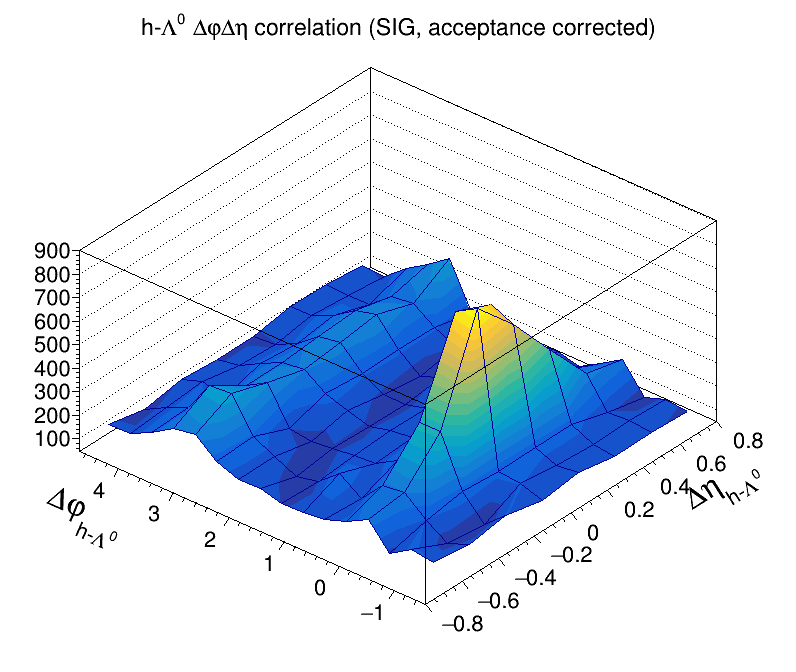

In [85]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_mixcor_sig_0_20.GetXaxis().SetRangeUser(DELTA_ETA_MIN, DELTA_ETA_MAX)
h_lambda_2d_mixcor_sig_0_20.Draw("SURF1")
c.Draw()

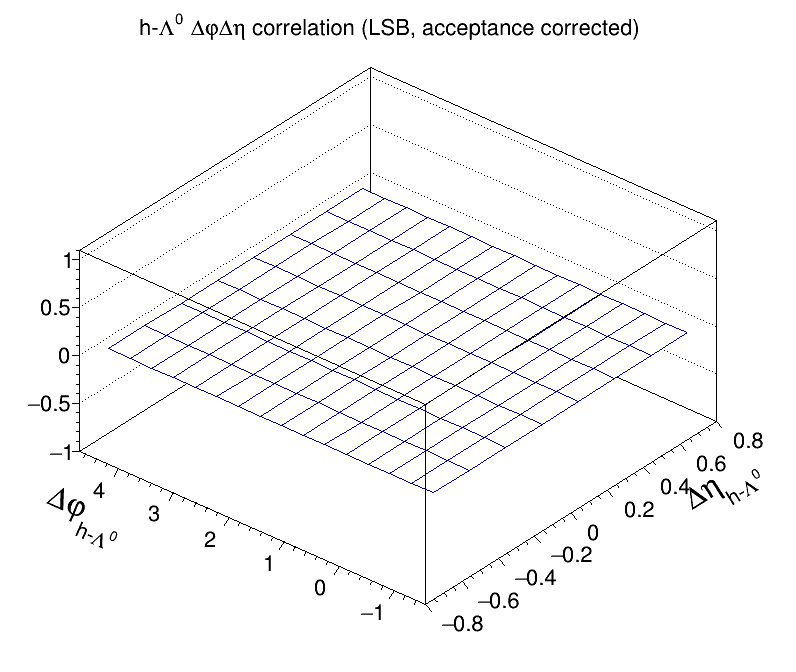

In [86]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_mixcor_lsb_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_mixcor_lsb_0_20.Draw("SURF1")
c.Draw()

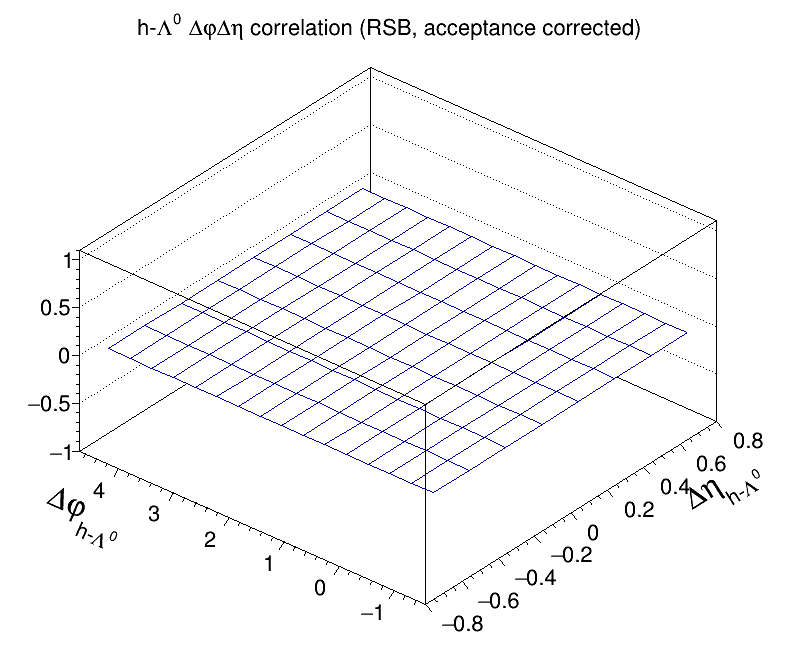

In [87]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_mixcor_rsb_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_mixcor_rsb_0_20.Draw("SURF1")
c.Draw()

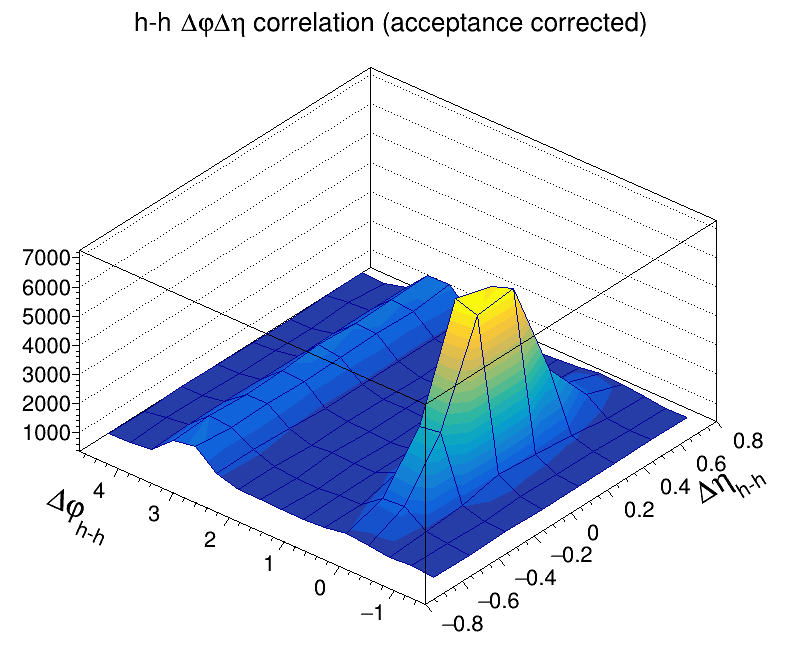

In [88]:
c.SetTheta(50)
c.SetPhi(50)
h_h_2d_mixcor_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_h_2d_mixcor_0_20.Draw("SURF1")
c.Draw()

In [89]:
h_lambda_2d_mixcor_sig_0_20_mc.GetXaxis().SetRangeUser(DELTA_ETA_MIN, DELTA_ETA_MAX)
h_h_2d_mixcor_0_20_mc.GetXaxis().SetRangeUser(DELTA_ETA_MIN, DELTA_ETA_MAX)

In [90]:
# per-trigger normalization done here
h_lambda_2d_mixcor_lsb_0_20.Scale(1.0/num_trigs_0_20)
h_lambda_2d_mixcor_sig_0_20.Scale(1.0/num_trigs_0_20)
h_lambda_2d_mixcor_rsb_0_20.Scale(1.0/num_trigs_0_20)
h_lambda_2d_mixcor_sig_0_20_mc.Scale(1.0/num_trigs_0_20_mc)
h_h_2d_mixcor_0_20.Scale(1.0/num_trigs_0_20)
h_h_2d_mixcor_0_20_mc.Scale(1.0/num_trigs_0_20_mc)

In [91]:
# MC truth does not need sideband subtraction
h_lambda_2d_subtracted_0_20_mc = h_lambda_2d_mixcor_sig_0_20_mc
h_lambda_2d_subtracted_0_20 = h_lambda_2d_mixcor_sig_0_20

### Sideband subtraction section

In [94]:
# Generate sum of 2 distributions (for USE_BOTH method)
h_lambda_2d_mixcor_rsblsb_0_20 = h_lambda_2d_mixcor_rsb_0_20.Clone("h_lambda_2d_mixcor_rsblsb_0_20")
h_lambda_2d_mixcor_rsblsb_0_20.Add(h_lambda_2d_mixcor_lsb_0_20)

True

In [185]:
# Normalize side bands to 1
h_lambda_2d_mixcor_rsblsb_0_20.Scale(1/h_lambda_2d_mixcor_rsblsb_0_20.Integral())
h_lambda_2d_mixcor_rsb_0_20.Scale(1/h_lambda_2d_mixcor_rsb_0_20.Integral())
h_lambda_2d_mixcor_lsb_0_20.Scale(1/h_lambda_2d_mixcor_lsb_0_20.Integral())

ZeroDivisionError: float division by zero

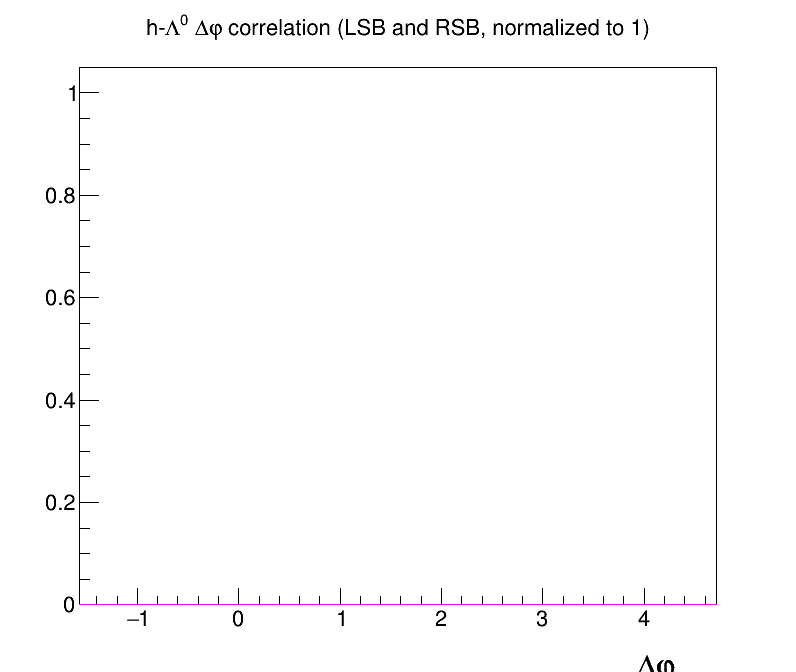

In [62]:
h_lambda_dphi_rsb_0_20 = h_lambda_2d_mixcor_rsb_0_20.ProjectionY("h_lambda_dphi_rsb_0_20")
h_lambda_dphi_lsb_0_20 = h_lambda_2d_mixcor_lsb_0_20.ProjectionY("h_lambda_dphi_lsb_0_20")
h_lambda_dphi_rsb_0_20.SetTitle("h-#Lambda^{0} #Delta#varphi correlation (RSB, acceptance corrected)")
h_lambda_dphi_rsb_0_20.SetLineColor(rt.kMagenta)
h_lambda_dphi_lsb_0_20.SetTitle("h-#Lambda^{0} #Delta#varphi correlation (LSB and RSB, normalized to 1)")
h_lambda_dphi_lsb_0_20.SetLineColor(rt.kBlue)
h_lambda_dphi_lsb_0_20.Draw()
h_lambda_dphi_rsb_0_20.Draw("SAME")
c.Draw()

In [ ]:
h_lambda_dphi_rsblsb_0_20 = h_lambda_2d_mixcor_rsb_0_20.ProjectionY("h_lambda_dphi_rsb_0_20")
h_lambda_dphi_rsblsb_0_20.SetTitle("h-#Lambda^{0} #Delta#varphi correlation (LSB + RSB, normalized to 1)")
h_lambda_dphi_rsblsb_0_20.SetLineColor(rt.kViolet + 4)
h_lambda_dphi_rsblsb_0_20.SetLineWidth(3)
h_lambda_dphi_rsblsb_0_20.Draw()
c.Draw()

In [ ]:
if USE_RSB:
    # using RSB for sideband subtraction
    h_lambda_2d_subtracted_0_20 = h_lambda_2d_mixcor_sig_0_20.Clone("h_lambda_2d_subtracted_0_20")
    bg_integral_0_20 = (1 - lambda_signal_total_ratio_0_20)*h_lambda_2d_subtracted_0_20.Integral()
    h_lambda_2d_subtracted_0_20.Add(h_lambda_2d_mixcor_rsb_0_20, -bg_integral_0_20)
elif USE_LSB:
    # using RSB for sideband subtraction
    h_lambda_2d_subtracted_0_20 = h_lambda_2d_mixcor_sig_0_20.Clone("h_lambda_2d_subtracted_0_20")
    bg_integral_0_20 = (1 - lambda_signal_total_ratio_0_20)*h_lambda_2d_subtracted_0_20.Integral()
    h_lambda_2d_subtracted_0_20.Add(h_lambda_2d_mixcor_lsb_0_20, -bg_integral_0_20)
elif USE_BOTH:
    # using RSB for sideband subtraction
    h_lambda_2d_subtracted_0_20 = h_lambda_2d_mixcor_sig_0_20.Clone("h_lambda_2d_subtracted_0_20")
    bg_integral_0_20 = (1 - lambda_signal_total_ratio_0_20)*h_lambda_2d_subtracted_0_20.Integral()
    h_lambda_2d_subtracted_0_20.Add(h_lambda_2d_mixcor_rsblsb_0_20, -bg_integral_0_20)
else:
    raise NotImplementedError("Must have USE_RSB or USE_LSB selected")

In [ ]:
h_lambda_2d_subtracted_0_20.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (acceptance corrected, right sideband subtracted)")
h_lambda_2d_subtracted_0_20.Draw("SURF1")
c.Draw()

### Integral and ratio section

In [92]:
h_lambda_dphi_subtracted_0_20 = h_lambda_2d_subtracted_0_20.ProjectionY("h_lambda_dphi_subtracted_0_20")
h_lambda_dphi_subtracted_0_20.SetTitle("h-#Lambda^{0} #Delta#varphi distribution (0 - 20 multiplicty bin)")
h_lambda_dphi_subtracted_0_20.SetLineColor(rt.kRed)
h_lambda_dphi_subtracted_0_20.SetLineWidth(3)
h_lambda_dphi_subtracted_0_20.GetYaxis().SetTitle("#frac{dN_{h-#Lambda^{0}}}{d#Delta#varphi}")
h_lambda_dphi_subtracted_0_20.GetXaxis().SetTitleSize(0.05)
h_lambda_dphi_subtracted_0_20.GetXaxis().SetTitleOffset(0.5)

In [93]:
h_lambda_dphi_subtracted_0_20_mc = h_lambda_2d_subtracted_0_20_mc.ProjectionY("h_lambda_dphi_subtracted_0_20_mc")
h_lambda_dphi_subtracted_0_20_mc.SetTitle("h-#Lambda^{0} #Delta#varphi distribution (0 - 20 multiplicty bin, MC truth)")
h_lambda_dphi_subtracted_0_20_mc.SetLineColor(rt.kBlue)
h_lambda_dphi_subtracted_0_20_mc.SetLineWidth(3)
h_lambda_dphi_subtracted_0_20_mc.GetYaxis().SetTitle("#frac{dN_{h-#Lambda^{0}}}{d#Delta#varphi}")
h_lambda_dphi_subtracted_0_20_mc.GetXaxis().SetTitleSize(0.05)
h_lambda_dphi_subtracted_0_20_mc.GetXaxis().SetTitleOffset(0.5)

In [94]:
b1, b2, b3, b4 = h_lambda_dphi_subtracted_0_20.GetBinContent(1), h_lambda_dphi_subtracted_0_20.GetBinContent(8), h_lambda_dphi_subtracted_0_20.GetBinContent(9), h_lambda_dphi_subtracted_0_20.GetBinContent(16)
b1_mc, b2_mc, b3_mc, b4_mc = h_lambda_dphi_subtracted_0_20_mc.GetBinContent(1), h_lambda_dphi_subtracted_0_20_mc.GetBinContent(8), h_lambda_dphi_subtracted_0_20_mc.GetBinContent(9), h_lambda_dphi_subtracted_0_20_mc.GetBinContent(16)
ue_avg = (b1 + b2 + b3 + b4)/4
ue_avg_mc = (b1_mc + b2_mc + b3_mc + b4_mc)/4
h_lambda_dphi_subtracted_0_20.Scale(ue_avg_mc/ue_avg)

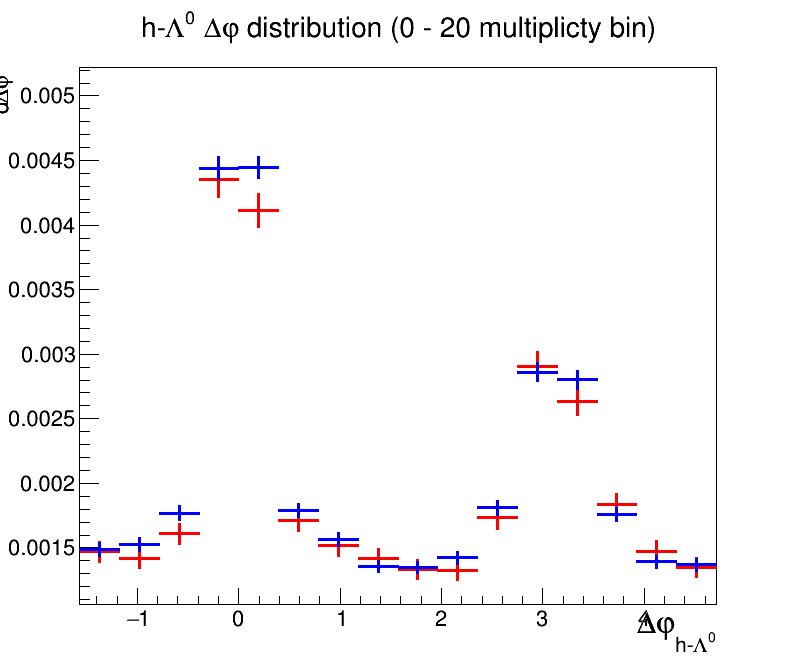

In [95]:
h_lambda_dphi_subtracted_0_20.Draw()
# h_lambda_dphi_subtracted_0_20.Rebin(2)
# h_lambda_dphi_subtracted_0_20_mc.Rebin(2)
h_lambda_dphi_subtracted_0_20.GetYaxis().SetRangeUser(h_lambda_dphi_subtracted_0_20.GetMinimum()*0.8, h_lambda_dphi_subtracted_0_20.GetMaximum()*1.2)
h_lambda_dphi_subtracted_0_20_mc.SetLineColor(rt.kBlue)

h_lambda_dphi_subtracted_0_20_mc.Draw("SAME")
c.Draw()


****************************************
Minimizer is Linear / Migrad
Chi2                      =      9.62722
NDf                       =           15
p0                        =     0.968362   +/-   0.0133398   


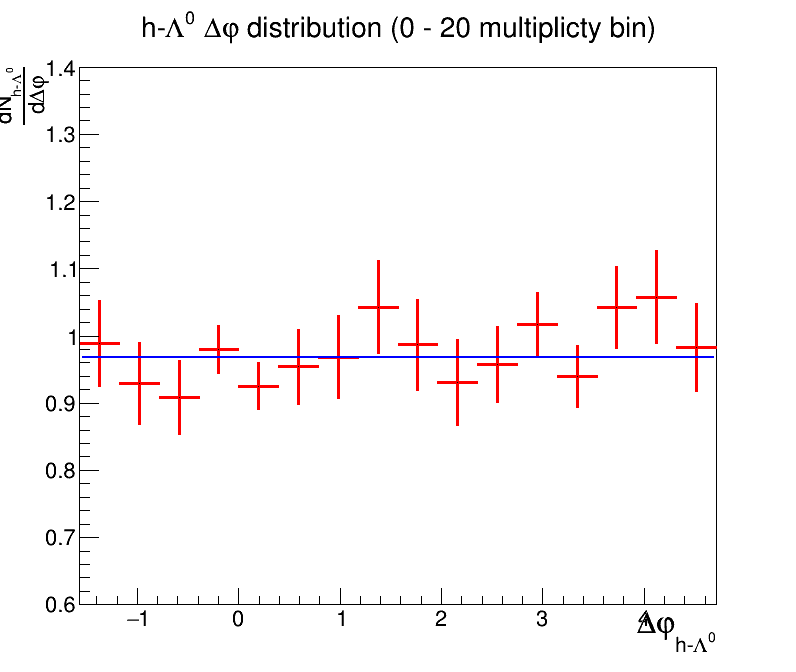

In [96]:
hl_closure_ratio_0_20_fit = rt.TF1("hl_closure_ratio_fit_0_20", "pol0", -2, 5)
hl_closure_ratio_0_20_fit.SetLineColor(rt.kBlue)
hl_closure_ratio_0_20_fit_plus = rt.TF1("hl_closure_ratio_fit_0_20_plus", "pol0", -2, 5)
hl_closure_ratio_0_20_fit_plus.SetLineColor(rt.kBlue)
hl_closure_ratio_0_20_fit_minus = rt.TF1("hl_closure_ratio_fit_0_20_minus", "pol0", -2, 5)
hl_closure_ratio_0_20_fit_minus.SetLineColor(rt.kBlue)
hl_closure_ratio_0_20_fit_minus.SetParameter(0, 0.967735 - 0.0261404)
hl_closure_ratio_0_20_fit_plus.SetLineStyle(10)
hl_closure_ratio_0_20_fit_plus.SetLineWidth(1)
hl_closure_ratio_0_20_fit_minus.SetLineStyle(10)
hl_closure_ratio_0_20_fit_minus.SetLineWidth(1)
hl_closure_ratio_0_20_fit_plus.SetParameter(0, 0.967735 + 0.0261404)
hl_closure_ratio_0_20_fit.SetLineStyle(10)
hl_closure_ratio_0_20_fit.SetLineWidth(2)
h_lambda_dphi_subtracted_0_20_ratio = h_lambda_dphi_subtracted_0_20.Clone("h_lambda_dphi_subtracted_0_20_ratio")
h_lambda_dphi_subtracted_0_20_ratio.Divide(h_lambda_dphi_subtracted_0_20_mc)
h_lambda_dphi_subtracted_0_20_ratio.GetYaxis().SetRangeUser(0.6, 1.4)
h_lambda_dphi_subtracted_0_20_ratio.Fit(hl_closure_ratio_0_20_fit)
h_lambda_dphi_subtracted_0_20_ratio.Draw()
# hl_closure_ratio_0_20_fit_plus.Draw("SAME")
# hl_closure_ratio_0_20_fit_minus.Draw("SAME")
c.Draw()

In [97]:
if USE_AVG:
    ue_line_0_20 = rt.TF1("ue_line_0_20", "pol0", -2, 6)
    ue_upper_line_0_20 = rt.TF1("ue_upper_line_0_20", "pol0", -2, 6)
    ue_lower_line_0_20 = rt.TF1("ue_lower_line_0_20", "pol0", -2, 6)
    zero_line_0_20 = rt.TF1("zero_line_0_20", "pol0", -2, 6)
    zero_upper_line_0_20 = rt.TF1("zero_upper_line_0_20", "pol0", -2, 6)
    zero_lower_line_0_20 = rt.TF1("zero_lower_line_0_20", "pol0", -2, 6)
    ue_avg_0_20 = (h_lambda_dphi_subtracted_0_20.GetBinContent(1) 
                   + h_lambda_dphi_subtracted_0_20.GetBinContent(8)
                   + h_lambda_dphi_subtracted_0_20.GetBinContent(9)
                   + h_lambda_dphi_subtracted_0_20.GetBinContent(16))/4

    ue_avg_error_0_20 = (1/4)*(math.sqrt(h_lambda_dphi_subtracted_0_20.GetBinError(1)**2 
                   + h_lambda_dphi_subtracted_0_20.GetBinError(8)**2
                   + h_lambda_dphi_subtracted_0_20.GetBinError(9)**2
                   + h_lambda_dphi_subtracted_0_20.GetBinError(16)**2))


    ue_line_0_20.SetParameter(0, ue_avg_0_20)
    ue_line_0_20.SetLineColor(rt.kViolet - 6)
    ue_line_0_20.SetLineWidth(3)
    ue_line_0_20.SetLineStyle(rt.kSolid)

    ue_upper_line_0_20.SetParameter(0, ue_avg_0_20 + ue_avg_error_0_20)
    ue_upper_line_0_20.SetLineColor(rt.kViolet - 6)
    ue_upper_line_0_20.SetLineStyle(rt.kDashed)

    ue_lower_line_0_20.SetParameter(0, ue_avg_0_20 - ue_avg_error_0_20)
    ue_lower_line_0_20.SetLineColor(rt.kViolet - 6)
    ue_lower_line_0_20.SetLineStyle(rt.kDashed)

    zero_line_0_20.SetParameter(0, 0)
    zero_line_0_20.SetLineColor(rt.kViolet - 6)
    zero_line_0_20.SetLineWidth(3)
    zero_line_0_20.SetLineStyle(rt.kSolid)
    zero_upper_line_0_20.SetParameter(0, ue_avg_error_0_20)
    zero_upper_line_0_20.SetLineColor(rt.kViolet - 6)
    zero_upper_line_0_20.SetLineStyle(rt.kDashed)
    zero_lower_line_0_20.SetParameter(0, -ue_avg_error_0_20)
    zero_lower_line_0_20.SetLineColor(rt.kViolet - 6)
    zero_lower_line_0_20.SetLineStyle(rt.kDashed)
elif USE_ZYAM:
    ue_line_0_20 = rt.TF1("ue_line_0_20", "pol0", -2, 6)
    ue_upper_line_0_20 = rt.TF1("ue_upper_line_0_20", "pol0", -2, 6)
    ue_lower_line_0_20 = rt.TF1("ue_lower_line_0_20", "pol0", -2, 6)
    zero_line_0_20 = rt.TF1("zero_line_0_20", "pol0", -2, 6)
    zero_upper_line_0_20 = rt.TF1("zero_upper_line_0_20", "pol0", -2, 6)
    zero_lower_line_0_20 = rt.TF1("zero_lower_line_0_20", "pol0", -2, 6)
    min_bin = h_lambda_dphi_subtracted_0_20.GetMinimumBin()
    ue_avg_0_20 = h_lambda_dphi_subtracted_0_20.GetBinContent(min_bin)
    ue_avg_error_0_20 = h_lambda_dphi_subtracted_0_20.GetBinError(min_bin)


    ue_line_0_20.SetParameter(0, ue_avg_0_20)
    ue_line_0_20.SetLineColor(rt.kViolet - 6)
    ue_line_0_20.SetLineWidth(3)
    ue_line_0_20.SetLineStyle(rt.kSolid)

    ue_upper_line_0_20.SetParameter(0, ue_avg_0_20 + ue_avg_error_0_20)
    ue_upper_line_0_20.SetLineColor(rt.kViolet - 6)
    ue_upper_line_0_20.SetLineStyle(rt.kDashed)

    ue_lower_line_0_20.SetParameter(0, ue_avg_0_20 - ue_avg_error_0_20)
    ue_lower_line_0_20.SetLineColor(rt.kViolet - 6)
    ue_lower_line_0_20.SetLineStyle(rt.kDashed)

    zero_line_0_20.SetParameter(0, 0)
    zero_line_0_20.SetLineColor(rt.kViolet - 6)
    zero_line_0_20.SetLineWidth(3)
    zero_line_0_20.SetLineStyle(rt.kSolid)
    zero_upper_line_0_20.SetParameter(0, ue_avg_error_0_20)
    zero_upper_line_0_20.SetLineColor(rt.kViolet - 6)
    zero_upper_line_0_20.SetLineStyle(rt.kDashed)
    zero_lower_line_0_20.SetParameter(0, -ue_avg_error_0_20)
    zero_lower_line_0_20.SetLineColor(rt.kViolet - 6)
    zero_lower_line_0_20.SetLineStyle(rt.kDashed)
else:
    raise NotImplementedError("UE line mode not supported")

In [98]:
if USE_AVG:
    ue_line_0_20_mc = rt.TF1("ue_line_0_20_mc", "pol0", -2, 6)
    ue_upper_line_0_20_mc = rt.TF1("ue_upper_line_0_20_mc", "pol0", -2, 6)
    ue_lower_line_0_20_mc = rt.TF1("ue_lower_line_0_20_mc", "pol0", -2, 6)
    zero_line_0_20_mc = rt.TF1("zero_line_0_20_mc", "pol0", -2, 6)
    zero_upper_line_0_20_mc = rt.TF1("zero_upper_line_0_20_mc", "pol0", -2, 6)
    zero_lower_line_0_20_mc = rt.TF1("zero_lower_line_0_20_mc", "pol0", -2, 6)
    ue_avg_0_20_mc = (h_lambda_dphi_subtracted_0_20_mc.GetBinContent(1) 
                   + h_lambda_dphi_subtracted_0_20_mc.GetBinContent(8)
                   + h_lambda_dphi_subtracted_0_20_mc.GetBinContent(9)
                   + h_lambda_dphi_subtracted_0_20_mc.GetBinContent(16))/4

    ue_avg_error_0_20_mc = (1/4)*(math.sqrt(h_lambda_dphi_subtracted_0_20_mc.GetBinError(1)**2 
                   + h_lambda_dphi_subtracted_0_20_mc.GetBinError(8)**2
                   + h_lambda_dphi_subtracted_0_20_mc.GetBinError(9)**2
                   + h_lambda_dphi_subtracted_0_20_mc.GetBinError(16)**2))


    ue_line_0_20_mc.SetParameter(0, ue_avg_0_20_mc)
    ue_line_0_20_mc.SetLineColor(rt.kViolet - 6)
    ue_line_0_20_mc.SetLineWidth(3)
    ue_line_0_20_mc.SetLineStyle(rt.kSolid)

    ue_upper_line_0_20_mc.SetParameter(0, ue_avg_0_20_mc + ue_avg_error_0_20_mc)
    ue_upper_line_0_20_mc.SetLineColor(rt.kViolet - 6)
    ue_upper_line_0_20_mc.SetLineStyle(rt.kDashed)

    ue_lower_line_0_20_mc.SetParameter(0, ue_avg_0_20_mc - ue_avg_error_0_20_mc)
    ue_lower_line_0_20_mc.SetLineColor(rt.kViolet - 6)
    ue_lower_line_0_20_mc.SetLineStyle(rt.kDashed)

    zero_line_0_20_mc.SetParameter(0, 0)
    zero_line_0_20_mc.SetLineColor(rt.kViolet - 6)
    zero_line_0_20_mc.SetLineWidth(3)
    zero_line_0_20_mc.SetLineStyle(rt.kSolid)
    zero_upper_line_0_20_mc.SetParameter(0, ue_avg_error_0_20_mc)
    zero_upper_line_0_20_mc.SetLineColor(rt.kViolet - 6)
    zero_upper_line_0_20_mc.SetLineStyle(rt.kDashed)
    zero_lower_line_0_20_mc.SetParameter(0, -ue_avg_error_0_20_mc)
    zero_lower_line_0_20_mc.SetLineColor(rt.kViolet - 6)
    zero_lower_line_0_20_mc.SetLineStyle(rt.kDashed)
elif USE_ZYAM:
    ue_line_0_20_mc = rt.TF1("ue_line_0_20_mc", "pol0", -2, 6)
    ue_upper_line_0_20_mc = rt.TF1("ue_upper_line_0_20_mc", "pol0", -2, 6)
    ue_lower_line_0_20_mc = rt.TF1("ue_lower_line_0_20_mc", "pol0", -2, 6)
    zero_line_0_20_mc = rt.TF1("zero_line_0_20_mc", "pol0", -2, 6)
    zero_upper_line_0_20_mc = rt.TF1("zero_upper_line_0_20_mc", "pol0", -2, 6)
    zero_lower_line_0_20_mc = rt.TF1("zero_lower_line_0_20_mc", "pol0", -2, 6)
    min_bin = h_lambda_dphi_subtracted_0_20_mc.GetMinimumBin()
    ue_avg_0_20_mc = h_lambda_dphi_subtracted_0_20_mc.GetBinContent(min_bin)
    ue_avg_error_0_20_mc = h_lambda_dphi_subtracted_0_20_mc.GetBinError(min_bin)


    ue_line_0_20_mc.SetParameter(0, ue_avg_0_20_mc)
    ue_line_0_20_mc.SetLineColor(rt.kViolet - 6)
    ue_line_0_20_mc.SetLineWidth(3)
    ue_line_0_20_mc.SetLineStyle(rt.kSolid)

    ue_upper_line_0_20_mc.SetParameter(0, ue_avg_0_20_mc + ue_avg_error_0_20_mc)
    ue_upper_line_0_20_mc.SetLineColor(rt.kViolet - 6)
    ue_upper_line_0_20_mc.SetLineStyle(rt.kDashed)

    ue_lower_line_0_20_mc.SetParameter(0, ue_avg_0_20_mc - ue_avg_error_0_20_mc)
    ue_lower_line_0_20_mc.SetLineColor(rt.kViolet - 6)
    ue_lower_line_0_20_mc.SetLineStyle(rt.kDashed)

    zero_line_0_20_mc.SetParameter(0, 0)
    zero_line_0_20_mc.SetLineColor(rt.kViolet - 6)
    zero_line_0_20_mc.SetLineWidth(3)
    zero_line_0_20_mc.SetLineStyle(rt.kSolid)
    zero_upper_line_0_20_mc.SetParameter(0, ue_avg_error_0_20_mc)
    zero_upper_line_0_20_mc.SetLineColor(rt.kViolet - 6)
    zero_upper_line_0_20_mc.SetLineStyle(rt.kDashed)
    zero_lower_line_0_20_mc.SetParameter(0, -ue_avg_error_0_20_mc)
    zero_lower_line_0_20_mc.SetLineColor(rt.kViolet - 6)
    zero_lower_line_0_20_mc.SetLineStyle(rt.kDashed)
else:
    raise NotImplementedError("UE line mode not supported")

In [ ]:
min_bin = h_lambda_dphi_subtracted_0_20.GetMinimumBin()
min_val = h_lambda_dphi_subtracted_0_20.GetBinContent(min_bin)
max_bin = h_lambda_dphi_subtracted_0_20.GetMaximumBin()
max_val = h_lambda_dphi_subtracted_0_20.GetBinContent(max_bin)

h_lambda_dphi_subtracted_0_20.GetYaxis().SetRangeUser(0.85*min_val, 1.15*max_val)
h_lambda_dphi_subtracted_0_20.Draw()
ue_line_0_20.Draw("SAME")
ue_upper_line_0_20.Draw("SAME")
ue_lower_line_0_20.Draw("SAME")
c.Draw()

In [ ]:
h_lambda_dphi_subtracted_0_20.GetYaxis().SetRangeUser(0, 1.15*max_val)
h_lambda_dphi_subtracted_0_20.Draw()
ue_line_0_20.Draw("SAME")
ue_upper_line_0_20.Draw("SAME")
ue_lower_line_0_20.Draw("SAME")
c.Draw()

In [ ]:
h_lambda_dphi_subtracted_0_20_zeroed = h_lambda_dphi_subtracted_0_20.Clone("h_lambda_dphi_subtracted_0_20_zeroed")
h_lambda_dphi_subtracted_0_20_zeroed.SetTitle("h-#Lambda^{0} #Delta#varphi distribution (UE subtracted, 0 - 20 multiplicity bin)")
h_lambda_dphi_subtracted_0_20_zeroed.Add(ue_line_0_20, -1)
h_lambda_dphi_subtracted_0_20_zeroed.Draw()
zero_line_0_20.Draw("SAME")
zero_upper_line_0_20.Draw("SAME")
zero_lower_line_0_20.Draw("SAME")
c.Draw()

In [ ]:
DPHI_BINS = h_lambda_dphi_subtracted_0_20.GetNbinsX()

In [ ]:
h_lambda_total_integral_0_20 = 0
h_lambda_near_integral_0_20 = 0
h_lambda_away_integral_0_20 = 0
h_lambda_ue_integral_0_20 = ue_avg_0_20*DPHI_BINS

h_lambda_total_integral_error_0_20 = 0
h_lambda_near_integral_error_0_20 = 0
h_lambda_away_integral_error_0_20 = 0
h_lambda_ue_integral_error_0_20 = ue_avg_error_0_20*DPHI_BINS

for bin_num in range(1, DPHI_BINS + 1):
    h_lambda_total_integral_0_20 += h_lambda_dphi_subtracted_0_20.GetBinContent(bin_num)
    h_lambda_total_integral_error_0_20 += h_lambda_dphi_subtracted_0_20.GetBinError(bin_num)**2
    part = h_lambda_dphi_subtracted_0_20.GetBinContent(bin_num) - ue_avg_0_20
    if part < 0:
        continue
    if bin_num < 9:
        h_lambda_near_integral_0_20 += part
        h_lambda_near_integral_error_0_20 += h_lambda_dphi_subtracted_0_20.GetBinError(bin_num)**2
        h_lambda_near_integral_error_0_20 += ue_avg_error_0_20**2
    else:
        h_lambda_away_integral_0_20 += part
        h_lambda_away_integral_error_0_20 += h_lambda_dphi_subtracted_0_20.GetBinError(bin_num)**2
        h_lambda_away_integral_error_0_20 += ue_avg_error_0_20**2
h_lambda_total_integral_error_0_20 = math.sqrt(h_lambda_total_integral_error_0_20)
h_lambda_near_integral_error_0_20 = math.sqrt(h_lambda_near_integral_error_0_20)
h_lambda_away_integral_error_0_20 = math.sqrt(h_lambda_away_integral_error_0_20)

In [ ]:
h_lambda_total_integral_0_20_mc = 0
h_lambda_near_integral_0_20_mc = 0
h_lambda_away_integral_0_20_mc = 0
h_lambda_ue_integral_0_20_mc = ue_avg_0_20_mc*DPHI_BINS

h_lambda_total_integral_error_0_20_mc = 0
h_lambda_near_integral_error_0_20_mc = 0
h_lambda_away_integral_error_0_20_mc = 0
h_lambda_ue_integral_error_0_20_mc = ue_avg_error_0_20_mc*DPHI_BINS

for bin_num in range(1, DPHI_BINS + 1):
    h_lambda_total_integral_0_20_mc += h_lambda_dphi_subtracted_0_20_mc.GetBinContent(bin_num)
    h_lambda_total_integral_error_0_20_mc += h_lambda_dphi_subtracted_0_20_mc.GetBinError(bin_num)**2
    part = h_lambda_dphi_subtracted_0_20_mc.GetBinContent(bin_num) - ue_avg_0_20_mc
    if part < 0:
        continue
    if bin_num < 9:
        h_lambda_near_integral_0_20_mc += part 
        h_lambda_near_integral_error_0_20_mc += h_lambda_dphi_subtracted_0_20_mc.GetBinError(bin_num)**2
        h_lambda_near_integral_error_0_20_mc += ue_avg_error_0_20_mc**2
    else:
        h_lambda_away_integral_0_20_mc += part 
        h_lambda_away_integral_error_0_20_mc += h_lambda_dphi_subtracted_0_20_mc.GetBinError(bin_num)**2
        h_lambda_away_integral_error_0_20_mc += ue_avg_error_0_20_mc**2
h_lambda_total_integral_error_0_20_mc = math.sqrt(h_lambda_total_integral_error_0_20_mc)
h_lambda_near_integral_error_0_20_mc = math.sqrt(h_lambda_near_integral_error_0_20_mc)
h_lambda_away_integral_error_0_20_mc = math.sqrt(h_lambda_away_integral_error_0_20_mc)

In [99]:
h_h_dphi_0_20 = h_h_2d_mixcor_0_20.ProjectionY("h_h_dphi_0_20")
h_h_dphi_0_20.SetTitle("h-h #Delta#varphi distribution (0 - 20 multiplicty bin)")
h_h_dphi_0_20.SetLineColor(rt.kRed)
h_h_dphi_0_20.SetLineWidth(3)
h_h_dphi_0_20.GetYaxis().SetTitle("#frac{dN_{h-h}}{d#Delta#varphi}")
h_h_dphi_0_20.GetXaxis().SetTitleSize(0.05)
h_h_dphi_0_20.GetXaxis().SetTitleOffset(0.5)

In [100]:
h_h_dphi_0_20_mc = h_h_2d_mixcor_0_20_mc.ProjectionY("h_h_dphi_0_20_mc")
h_h_dphi_0_20_mc.SetTitle("h-h #Delta#varphi distribution (0 - 20 multiplicty bin)")
h_h_dphi_0_20_mc.SetLineColor(rt.kBlue)
h_h_dphi_0_20_mc.SetLineWidth(3)
h_h_dphi_0_20_mc.GetYaxis().SetTitle("#frac{dN_{h-h}}{d#Delta#varphi}")
h_h_dphi_0_20_mc.GetXaxis().SetTitleSize(0.05)
h_h_dphi_0_20_mc.GetXaxis().SetTitleOffset(0.5)

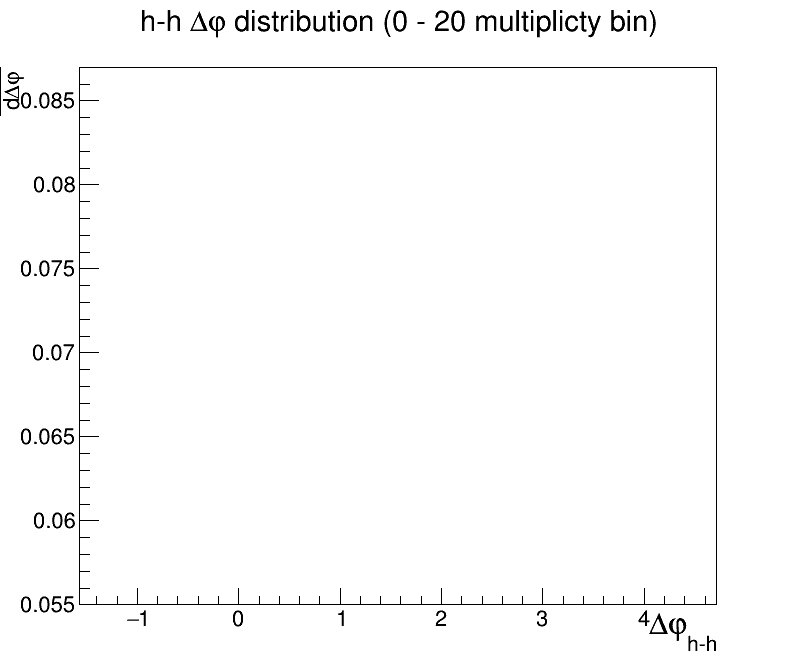

In [101]:
h_h_dphi_0_20.Scale(1/h_h_dphi_0_20.Integral())
h_h_dphi_0_20_mc.Scale(1/h_h_dphi_0_20_mc.Integral())
h_h_dphi_0_20.Draw()
h_h_dphi_0_20_mc.Draw("SAME")
c.Draw()


****************************************
Minimizer is Linear / Migrad
Chi2                      =      205.458
NDf                       =           15
p0                        =      1.03647   +/-   0.0048987   


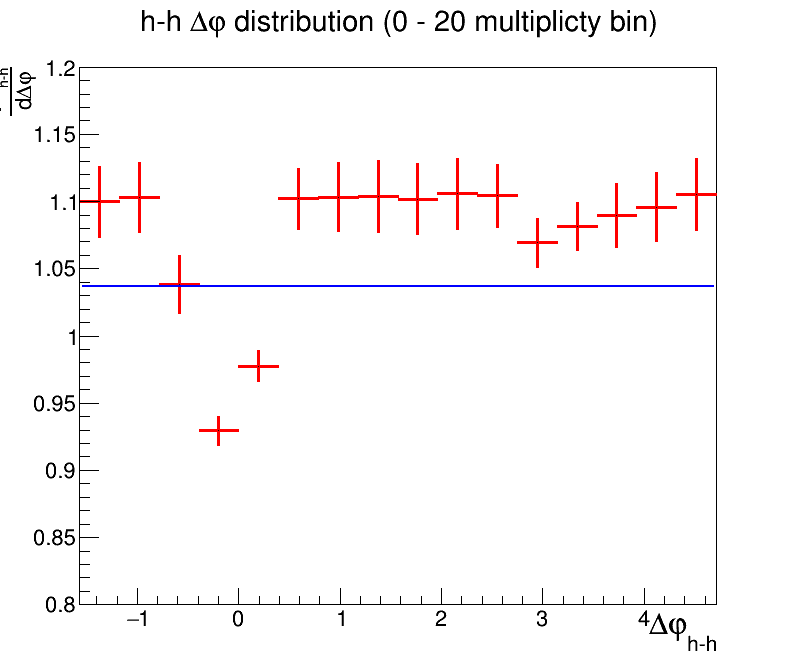

In [102]:
hh_closure_ratio_0_20_fit = rt.TF1("hh_closure_ratio_fit_0_20", "pol0", -2, 5)
hh_closure_ratio_0_20_fit.SetLineColor(rt.kBlue)
hh_closure_ratio_0_20_fit_plus = rt.TF1("hh_closure_ratio_fit_0_20_plus", "pol0", -2, 5)
hh_closure_ratio_0_20_fit_plus.SetLineColor(rt.kBlue)
hh_closure_ratio_0_20_fit_minus = rt.TF1("hh_closure_ratio_fit_0_20_minus", "pol0", -2, 5)
hh_closure_ratio_0_20_fit_minus.SetLineColor(rt.kBlue)
hh_closure_ratio_0_20_fit_minus.SetParameter(0, 1.00181 - 0.00373534)
hh_closure_ratio_0_20_fit_plus.SetLineStyle(10)
hh_closure_ratio_0_20_fit_plus.SetLineWidth(1)
hh_closure_ratio_0_20_fit_minus.SetLineStyle(10)
hh_closure_ratio_0_20_fit_minus.SetLineWidth(1)
hh_closure_ratio_0_20_fit_plus.SetParameter(0, 1.00181 + 0.00373534)
hh_closure_ratio_0_20_fit.SetLineStyle(10)
hh_closure_ratio_0_20_fit.SetLineWidth(2)
h_h_dphi_0_20.Divide(h_h_dphi_0_20_mc)
h_h_dphi_0_20.Fit(hh_closure_ratio_0_20_fit)
h_h_dphi_0_20.GetYaxis().SetRangeUser(0.8, 1.2)
h_h_dphi_0_20.Draw()
# hh_closure_ratio_0_20_fit_minus.Draw("SAME")
# hh_closure_ratio_0_20_fit_plus.Draw("SAME")

c.Draw()

In [103]:
if USE_AVG:
    hh_ue_line_0_20 = rt.TF1("hh_ue_line_0_20", "pol0", -2, 6)
    hh_ue_upper_line_0_20 = rt.TF1("hh_ue_upper_line_0_20", "pol0", -2, 6)
    hh_ue_lower_line_0_20 = rt.TF1("hh_ue_lower_line_0_20", "pol0", -2, 6)
    hh_zero_line_0_20 = rt.TF1("hh_zero_line_0_20", "pol0", -2, 6)
    hh_zero_upper_line_0_20 = rt.TF1("hh_zero_upper_line_0_20", "pol0", -2, 6)
    hh_zero_lower_line_0_20 = rt.TF1("hh_zero_lower_line_0_20", "pol0", -2, 6)
    hh_ue_avg_0_20 = (h_h_dphi_0_20.GetBinContent(1) 
                   + h_h_dphi_0_20.GetBinContent(8)
                   + h_h_dphi_0_20.GetBinContent(9)
                   + h_h_dphi_0_20.GetBinContent(16))/4

    hh_ue_avg_error_0_20 = (1/4)*(math.sqrt(h_h_dphi_0_20.GetBinError(1)**2 
                   + h_h_dphi_0_20.GetBinError(8)**2
                   + h_h_dphi_0_20.GetBinError(9)**2
                   + h_h_dphi_0_20.GetBinError(16)**2))


    hh_ue_line_0_20.SetParameter(0, hh_ue_avg_0_20)
    hh_ue_line_0_20.SetLineColor(rt.kBlue)
    hh_ue_line_0_20.SetLineWidth(3)
    hh_ue_line_0_20.SetLineStyle(rt.kSolid)

    hh_ue_upper_line_0_20.SetParameter(0, hh_ue_avg_0_20 + hh_ue_avg_error_0_20)
    hh_ue_upper_line_0_20.SetLineColor(rt.kBlue)
    hh_ue_upper_line_0_20.SetLineStyle(rt.kDashed)

    hh_ue_lower_line_0_20.SetParameter(0, hh_ue_avg_0_20 - hh_ue_avg_error_0_20)
    hh_ue_lower_line_0_20.SetLineColor(rt.kBlue)
    hh_ue_lower_line_0_20.SetLineStyle(rt.kDashed)

    hh_zero_line_0_20.SetParameter(0, 0)
    hh_zero_line_0_20.SetLineColor(rt.kBlue)
    hh_zero_line_0_20.SetLineWidth(3)
    hh_zero_line_0_20.SetLineStyle(rt.kSolid)
    hh_zero_upper_line_0_20.SetParameter(0, hh_ue_avg_error_0_20)
    hh_zero_upper_line_0_20.SetLineColor(rt.kBlue)
    hh_zero_upper_line_0_20.SetLineStyle(rt.kDashed)
    hh_zero_lower_line_0_20.SetParameter(0, -hh_ue_avg_error_0_20)
    hh_zero_lower_line_0_20.SetLineColor(rt.kBlue)
    hh_zero_lower_line_0_20.SetLineStyle(rt.kDashed)
elif USE_ZYAM:
    hh_ue_line_0_20 = rt.TF1("hh_ue_line_0_20", "pol0", -2, 6)
    hh_ue_upper_line_0_20 = rt.TF1("hh_ue_upper_line_0_20", "pol0", -2, 6)
    hh_ue_lower_line_0_20 = rt.TF1("hh_ue_lower_line_0_20", "pol0", -2, 6)
    hh_zero_line_0_20 = rt.TF1("hh_zero_line_0_20", "pol0", -2, 6)
    hh_zero_upper_line_0_20 = rt.TF1("hh_zero_upper_line_0_20", "pol0", -2, 6)
    hh_zero_lower_line_0_20 = rt.TF1("hh_zero_lower_line_0_20", "pol0", -2, 6)
    
    min_bin = h_h_dphi_0_20.GetMinimumBin()
    hh_ue_avg_0_20 = h_h_dphi_0_20.GetBinContent(min_bin)
    hh_ue_avg_error_0_20 = h_h_dphi_0_20.GetBinError(min_bin)

    hh_ue_line_0_20.SetParameter(0, hh_ue_avg_0_20)
    hh_ue_line_0_20.SetLineColor(rt.kBlue)
    hh_ue_line_0_20.SetLineWidth(3)
    hh_ue_line_0_20.SetLineStyle(rt.kSolid)

    hh_ue_upper_line_0_20.SetParameter(0, hh_ue_avg_0_20 + hh_ue_avg_error_0_20)
    hh_ue_upper_line_0_20.SetLineColor(rt.kBlue)
    hh_ue_upper_line_0_20.SetLineStyle(rt.kDashed)

    hh_ue_lower_line_0_20.SetParameter(0, hh_ue_avg_0_20 - hh_ue_avg_error_0_20)
    hh_ue_lower_line_0_20.SetLineColor(rt.kBlue)
    hh_ue_lower_line_0_20.SetLineStyle(rt.kDashed)

    hh_zero_line_0_20.SetParameter(0, 0)
    hh_zero_line_0_20.SetLineColor(rt.kBlue)
    hh_zero_line_0_20.SetLineWidth(3)
    hh_zero_line_0_20.SetLineStyle(rt.kSolid)
    hh_zero_upper_line_0_20.SetParameter(0, hh_ue_avg_error_0_20)
    hh_zero_upper_line_0_20.SetLineColor(rt.kBlue)
    hh_zero_upper_line_0_20.SetLineStyle(rt.kDashed)
    hh_zero_lower_line_0_20.SetParameter(0, -hh_ue_avg_error_0_20)
    hh_zero_lower_line_0_20.SetLineColor(rt.kBlue)
    hh_zero_lower_line_0_20.SetLineStyle(rt.kDashed)
else:
    raise NotImplementedError("UE line mode not supported")

In [ ]:
if USE_AVG:
    hh_ue_line_0_20_mc = rt.TF1("hh_ue_line_0_20_mc", "pol0", -2, 6)
    hh_ue_upper_line_0_20_mc = rt.TF1("hh_ue_upper_line_0_20_mc", "pol0", -2, 6)
    hh_ue_lower_line_0_20_mc = rt.TF1("hh_ue_lower_line_0_20_mc", "pol0", -2, 6)
    hh_zero_line_0_20_mc = rt.TF1("hh_zero_line_0_20_mc", "pol0", -2, 6)
    hh_zero_upper_line_0_20_mc = rt.TF1("hh_zero_upper_line_0_20_mc", "pol0", -2, 6)
    hh_zero_lower_line_0_20_mc = rt.TF1("hh_zero_lower_line_0_20_mc", "pol0", -2, 6)
    hh_ue_avg_0_20_mc = (h_h_dphi_0_20_mc.GetBinContent(1) 
                   + h_h_dphi_0_20_mc.GetBinContent(8)
                   + h_h_dphi_0_20_mc.GetBinContent(9)
                   + h_h_dphi_0_20_mc.GetBinContent(16))/4

    hh_ue_avg_error_0_20_mc = (1/4)*(math.sqrt(h_h_dphi_0_20_mc.GetBinError(1)**2 
                   + h_h_dphi_0_20_mc.GetBinError(8)**2
                   + h_h_dphi_0_20_mc.GetBinError(9)**2
                   + h_h_dphi_0_20_mc.GetBinError(16)**2))


    hh_ue_line_0_20_mc.SetParameter(0, hh_ue_avg_0_20_mc)
    hh_ue_line_0_20_mc.SetLineColor(rt.kBlue)
    hh_ue_line_0_20_mc.SetLineWidth(3)
    hh_ue_line_0_20_mc.SetLineStyle(rt.kSolid)

    hh_ue_upper_line_0_20_mc.SetParameter(0, hh_ue_avg_0_20_mc + hh_ue_avg_error_0_20_mc)
    hh_ue_upper_line_0_20_mc.SetLineColor(rt.kBlue)
    hh_ue_upper_line_0_20_mc.SetLineStyle(rt.kDashed)

    hh_ue_lower_line_0_20_mc.SetParameter(0, hh_ue_avg_0_20_mc - hh_ue_avg_error_0_20_mc)
    hh_ue_lower_line_0_20_mc.SetLineColor(rt.kBlue)
    hh_ue_lower_line_0_20_mc.SetLineStyle(rt.kDashed)

    hh_zero_line_0_20_mc.SetParameter(0, 0)
    hh_zero_line_0_20_mc.SetLineColor(rt.kBlue)
    hh_zero_line_0_20_mc.SetLineWidth(3)
    hh_zero_line_0_20_mc.SetLineStyle(rt.kSolid)
    hh_zero_upper_line_0_20_mc.SetParameter(0, hh_ue_avg_error_0_20_mc)
    hh_zero_upper_line_0_20_mc.SetLineColor(rt.kBlue)
    hh_zero_upper_line_0_20_mc.SetLineStyle(rt.kDashed)
    hh_zero_lower_line_0_20_mc.SetParameter(0, -hh_ue_avg_error_0_20_mc)
    hh_zero_lower_line_0_20_mc.SetLineColor(rt.kBlue)
    hh_zero_lower_line_0_20_mc.SetLineStyle(rt.kDashed)
elif USE_ZYAM:
    hh_ue_line_0_20_mc = rt.TF1("hh_ue_line_0_20_mc", "pol0", -2, 6)
    hh_ue_upper_line_0_20_mc = rt.TF1("hh_ue_upper_line_0_20_mc", "pol0", -2, 6)
    hh_ue_lower_line_0_20_mc = rt.TF1("hh_ue_lower_line_0_20_mc", "pol0", -2, 6)
    hh_zero_line_0_20_mc = rt.TF1("hh_zero_line_0_20_mc", "pol0", -2, 6)
    hh_zero_upper_line_0_20_mc = rt.TF1("hh_zero_upper_line_0_20_mc", "pol0", -2, 6)
    hh_zero_lower_line_0_20_mc = rt.TF1("hh_zero_lower_line_0_20_mc", "pol0", -2, 6)
    
    min_bin = h_h_dphi_0_20_mc.GetMinimumBin()
    hh_ue_avg_0_20_mc = h_h_dphi_0_20_mc.GetBinContent(min_bin)
    hh_ue_avg_error_0_20_mc = h_h_dphi_0_20_mc.GetBinError(min_bin)

    hh_ue_line_0_20_mc.SetParameter(0, hh_ue_avg_0_20_mc)
    hh_ue_line_0_20_mc.SetLineColor(rt.kBlue)
    hh_ue_line_0_20_mc.SetLineWidth(3)
    hh_ue_line_0_20_mc.SetLineStyle(rt.kSolid)

    hh_ue_upper_line_0_20_mc.SetParameter(0, hh_ue_avg_0_20_mc + hh_ue_avg_error_0_20_mc)
    hh_ue_upper_line_0_20_mc.SetLineColor(rt.kBlue)
    hh_ue_upper_line_0_20_mc.SetLineStyle(rt.kDashed)

    hh_ue_lower_line_0_20_mc.SetParameter(0, hh_ue_avg_0_20_mc - hh_ue_avg_error_0_20_mc)
    hh_ue_lower_line_0_20_mc.SetLineColor(rt.kBlue)
    hh_ue_lower_line_0_20_mc.SetLineStyle(rt.kDashed)

    hh_zero_line_0_20_mc.SetParameter(0, 0)
    hh_zero_line_0_20_mc.SetLineColor(rt.kBlue)
    hh_zero_line_0_20_mc.SetLineWidth(3)
    hh_zero_line_0_20_mc.SetLineStyle(rt.kSolid)
    hh_zero_upper_line_0_20_mc.SetParameter(0, hh_ue_avg_error_0_20_mc)
    hh_zero_upper_line_0_20_mc.SetLineColor(rt.kBlue)
    hh_zero_upper_line_0_20_mc.SetLineStyle(rt.kDashed)
    hh_zero_lower_line_0_20_mc.SetParameter(0, -hh_ue_avg_error_0_20_mc)
    hh_zero_lower_line_0_20_mc.SetLineColor(rt.kBlue)
    hh_zero_lower_line_0_20_mc.SetLineStyle(rt.kDashed)
else:
    raise NotImplementedError("UE line mode not supported")

In [ ]:
min_bin = h_h_dphi_0_20.GetMinimumBin()
min_val = h_h_dphi_0_20.GetBinContent(min_bin)
max_bin = h_h_dphi_0_20.GetMaximumBin()
max_val = h_h_dphi_0_20.GetBinContent(max_bin)

h_h_dphi_0_20.GetYaxis().SetRangeUser(0.85*min_val, 1.15*max_val)

h_h_dphi_0_20.Draw()
hh_ue_line_0_20.Draw("SAME")
hh_ue_upper_line_0_20.Draw("SAME")
hh_ue_lower_line_0_20.Draw("SAME")
c.Draw()

In [ ]:
h_h_dphi_0_20.GetYaxis().SetRangeUser(0, h_h_dphi_0_20.GetMaximum()*1.1)
h_h_dphi_0_20.Draw()
hh_ue_line_0_20.Draw("SAME")
hh_ue_upper_line_0_20.Draw("SAME")
hh_ue_lower_line_0_20.Draw("SAME")
c.Draw()

In [ ]:
h_h_dphi_0_20_zeroed = h_h_dphi_0_20.Clone("h_h_dphi_0_20_zeroed")
h_h_dphi_0_20_zeroed.SetTitle("h-h #Delta#varphi distribution (UE subtracted, 0 - 20 multiplicity bin)")
h_h_dphi_0_20_zeroed.Add(hh_ue_line_0_20, -1)
h_h_dphi_0_20_zeroed.Draw()
hh_zero_line_0_20.Draw("SAME")
hh_zero_upper_line_0_20.Draw("SAME")
hh_zero_lower_line_0_20.Draw("SAME")
c.Draw()

In [ ]:
h_h_total_integral_0_20 = 0
h_h_near_integral_0_20 = 0
h_h_away_integral_0_20 = 0
h_h_ue_integral_0_20 = hh_ue_avg_0_20*DPHI_BINS

h_h_total_integral_error_0_20 = 0
h_h_near_integral_error_0_20 = 0
h_h_away_integral_error_0_20 = 0
h_h_ue_integral_error_0_20 = hh_ue_avg_error_0_20*DPHI_BINS

for bin_num in range(1, DPHI_BINS + 1):
    h_h_total_integral_0_20 += h_h_dphi_0_20.GetBinContent(bin_num)
    h_h_total_integral_error_0_20 += h_h_dphi_0_20.GetBinError(bin_num)**2
    part = h_h_dphi_0_20.GetBinContent(bin_num) - hh_ue_avg_0_20
    if part < 0:
        continue
    if bin_num < 9:
        h_h_near_integral_0_20 += part
        h_h_near_integral_error_0_20 += h_h_dphi_0_20.GetBinError(bin_num)**2
        h_h_near_integral_error_0_20 += hh_ue_avg_error_0_20**2
    else:
        h_h_away_integral_0_20 += part
        h_h_away_integral_error_0_20 += h_h_dphi_0_20.GetBinError(bin_num)**2
        h_h_away_integral_error_0_20 += hh_ue_avg_error_0_20**2
h_h_total_integral_error_0_20 = math.sqrt(h_h_total_integral_error_0_20)
h_h_near_integral_error_0_20 = math.sqrt(h_h_near_integral_error_0_20)
h_h_away_integral_error_0_20 = math.sqrt(h_h_away_integral_error_0_20)

In [ ]:
h_h_total_integral_0_20_mc = 0
h_h_near_integral_0_20_mc = 0
h_h_away_integral_0_20_mc = 0
h_h_ue_integral_0_20_mc = hh_ue_avg_0_20_mc*DPHI_BINS

h_h_total_integral_error_0_20_mc = 0
h_h_near_integral_error_0_20_mc = 0
h_h_away_integral_error_0_20_mc = 0
h_h_ue_integral_error_0_20_mc = hh_ue_avg_error_0_20_mc*DPHI_BINS

for bin_num in range(1, DPHI_BINS + 1):
    h_h_total_integral_0_20_mc += h_h_dphi_0_20_mc.GetBinContent(bin_num)
    h_h_total_integral_error_0_20_mc += h_h_dphi_0_20_mc.GetBinError(bin_num)**2
    part = h_h_dphi_0_20_mc.GetBinContent(bin_num) - hh_ue_avg_0_20_mc
    if part < 0:
        continue
    if bin_num < 9:
        h_h_near_integral_0_20_mc += part
        h_h_near_integral_error_0_20_mc += h_h_dphi_0_20_mc.GetBinError(bin_num)**2
        h_h_near_integral_error_0_20_mc += hh_ue_avg_error_0_20_mc**2
    else:
        h_h_away_integral_0_20_mc += part
        h_h_away_integral_error_0_20_mc += h_h_dphi_0_20_mc.GetBinError(bin_num)**2
        h_h_away_integral_error_0_20_mc += hh_ue_avg_error_0_20_mc**2
h_h_total_integral_error_0_20_mc = math.sqrt(h_h_total_integral_error_0_20_mc)
h_h_near_integral_error_0_20_mc = math.sqrt(h_h_near_integral_error_0_20_mc)
h_h_away_integral_error_0_20_mc = math.sqrt(h_h_away_integral_error_0_20_mc)

In [ ]:
near_ratio_0_20 = h_lambda_near_integral_0_20/h_h_near_integral_0_20
away_ratio_0_20 = h_lambda_away_integral_0_20/h_h_away_integral_0_20
ue_ratio_0_20 = h_lambda_ue_integral_0_20/h_h_ue_integral_0_20
total_ratio_0_20 = h_lambda_total_integral_0_20/h_h_total_integral_0_20

near_ratio_error_0_20 = near_ratio_0_20*math.sqrt((h_lambda_near_integral_error_0_20/h_lambda_near_integral_0_20)**2
                                                 + (h_h_near_integral_error_0_20/h_h_near_integral_0_20)**2)
away_ratio_error_0_20 = away_ratio_0_20*math.sqrt((h_lambda_away_integral_error_0_20/h_lambda_away_integral_0_20)**2
                                                 + (h_h_away_integral_error_0_20/h_h_away_integral_0_20)**2)
ue_ratio_error_0_20 = ue_ratio_0_20*math.sqrt((h_lambda_ue_integral_error_0_20/h_lambda_ue_integral_0_20)**2
                                                 + (h_h_ue_integral_error_0_20/h_h_ue_integral_0_20)**2)
total_ratio_error_0_20 = total_ratio_0_20*math.sqrt((h_lambda_total_integral_error_0_20/h_lambda_total_integral_0_20)**2
                                                 + (h_h_total_integral_error_0_20/h_h_total_integral_0_20)**2)

In [ ]:
near_ratio_0_20_mc = h_lambda_near_integral_0_20_mc/h_h_near_integral_0_20_mc
away_ratio_0_20_mc = h_lambda_away_integral_0_20_mc/h_h_away_integral_0_20_mc
ue_ratio_0_20_mc = h_lambda_ue_integral_0_20_mc/h_h_ue_integral_0_20_mc
total_ratio_0_20_mc = h_lambda_total_integral_0_20_mc/h_h_total_integral_0_20_mc

near_ratio_error_0_20_mc = near_ratio_0_20_mc*math.sqrt((h_lambda_near_integral_error_0_20_mc/h_lambda_near_integral_0_20_mc)**2
                                                 + (h_h_near_integral_error_0_20_mc/h_h_near_integral_0_20_mc)**2)
away_ratio_error_0_20_mc = away_ratio_0_20_mc*math.sqrt((h_lambda_away_integral_error_0_20_mc/h_lambda_away_integral_0_20_mc)**2
                                                 + (h_h_away_integral_error_0_20_mc/h_h_away_integral_0_20_mc)**2)
ue_ratio_error_0_20_mc = ue_ratio_0_20_mc*math.sqrt((h_lambda_ue_integral_error_0_20_mc/h_lambda_ue_integral_0_20_mc)**2
                                                 + (h_h_ue_integral_error_0_20_mc/h_h_ue_integral_0_20_mc)**2)
total_ratio_error_0_20_mc = total_ratio_0_20_mc*math.sqrt((h_lambda_total_integral_error_0_20_mc/h_lambda_total_integral_0_20_mc)**2
                                                 + (h_h_total_integral_error_0_20_mc/h_h_total_integral_0_20_mc)**2)